In [1]:
import logging
logging.basicConfig(level = logging.ERROR)
from IPython.display import clear_output
logging.getLogger('prophet').setLevel(logging.ERROR) 
logging.getLogger('fbprophet').setLevel(logging.ERROR) 


from prophet import Prophet

%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

模型对象

In [2]:
model = Prophet()

*与sklearn不同， fit接口输入的数据只有df，且df必须满足特定的格式，df相当于X和y搞在一起了*

In [3]:
model.fit

Signature: model.fit(df, **kwargs)
Docstring:
Fit the Prophet model.

This sets self.params to contain the fitted model parameters. It is a
dictionary parameter names as keys and the following items:
    k (Mx1 array): M posterior samples of the initial slope.
    m (Mx1 array): The initial intercept.
    delta (MxN array): The slope change at each of N changepoints.
    beta (MxK matrix): Coefficients for K seasonality features.
    sigma_obs (Mx1 array): Noise level.
Note that M=1 if MAP estimation.

Parameters
----------
df: pd.DataFrame containing the history. Must have columns ds (date
    type) and y, the time series. If self.growth is 'logistic', then
    df must also have a column cap that specifies the capacity at
    each ds.
kwargs: Additional arguments passed to the optimizing or sampling
    functions in Stan.

Returns
-------
The fitted Prophet object.
File:      /opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py
Type:      method


predict的接口也不太一样，它不要求我们输入特征，而是要求我们输入一个df， pd.DataFrame with dates for predictions (column ds)， 只要求了一个ds列

In [4]:
model.predict?

Signature: model.predict(df=None)
Docstring:
Predict using the prophet model.

Parameters
----------
df: pd.DataFrame with dates for predictions (column ds), and capacity
    (column cap) if logistic growth. If not provided, predictions are
    made on the history.

Returns
-------
A pd.DataFrame with the forecast components.
File:      /opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py
Type:      method


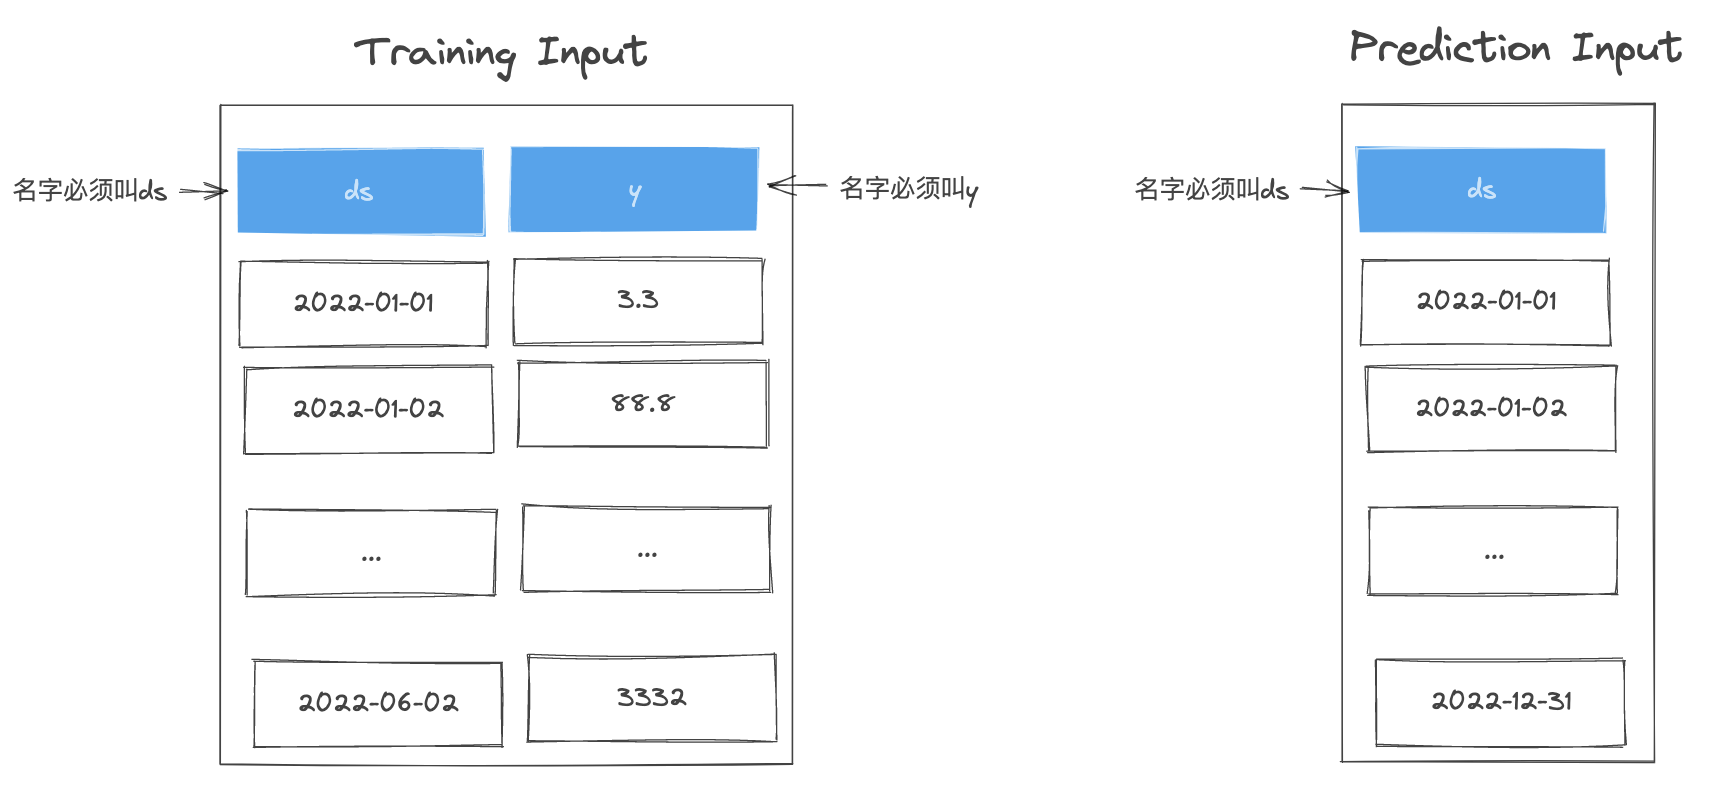

## Problem to Solve: Seasonality At multiple Scale

## $y(t) = g(t) + s(t) + h(t) + \epsilon(t)$ trend + seasonal + holiday + error

- 时间是唯一的特征，且不是auto regreesive的
- trend: piece wise linear / changepoint 或者 logistic growth (分段线性)    

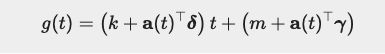
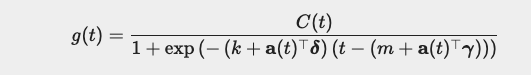

- Seasonal 傅立叶级数        
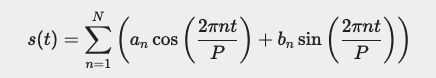

- holiday       
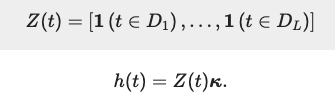     


Prophet模型的每一个参数都有自己的先验， Prior，经过一个贝叶斯模型，使用mcmc估计后验参数，得到模型参数的估计。      

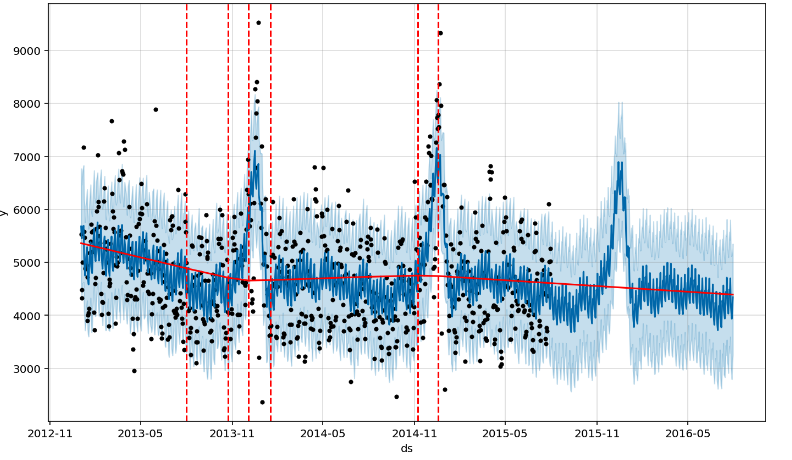

In [10]:
# from datetime import datetime, timedelta, date

# [datetime.now(), datetime.now() + timedelta(days = 1)]

In [5]:
Prophet?

Init signature:
Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)
Docstring:     
Prophet forecaster.

Parameters
----------
growth: String 'linear' or 'logistic' to specify a linear or logistic
    trend.
changepoints: List of dates at which to include potential changepoints. If
    not specified, potential changepoints are selected automatically.
n_changepoints: Number of potential changepoints to include. Not used
    if input `changepoints` is supplied. If `changepoints` is not supplied,
    then n_changepoints potential changepoints are selected uniformly from
    the first `changepoint_range`

## PYMC3

#### 数据探索

In [12]:
file_path = "./data_files/time_series_analysis/rossmann_train.csv"
sales = pd.read_csv(file_path, low_memory = False)

In [13]:
sales

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0            1          5  2015-07-31   5263        555     1      1   
1            2          5  2015-07-31   6064        625     1      1   
2            3          5  2015-07-31   8314        821     1      1   
3            4          5  2015-07-31  13995       1498     1      1   
4            5          5  2015-07-31   4822        559     1      1   
...        ...        ...         ...    ...        ...   ...    ...   
1017204   1111          2  2013-01-01      0          0     0      0   
1017205   1112          2  2013-01-01      0          0     0      0   
1017206   1113          2  2013-01-01      0          0     0      0   
1017207   1114          2  2013-01-01      0          0     0      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
0                  0              1  
1                  0              1  
2                  0              1  
3                  0              1  
4                  0              1  
...              ...            ...  
1017204            a              1  
1017205            a              1  
1017206            a              1  
1017207            a              1  
1017208            a              1  

[1017209 rows x 9 columns]

1. 一般的时间序列数据，喜欢吧datetime的时间标签列，放在index上，很多dataframe的操作对这个形式比较友好。
2. Prophet明确说了，datetime的标签ds，要放在column里面。

In [14]:
sales.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [15]:
df = pd.read_csv(file_path, low_memory=False, index_col = "Date", parse_dates = True)

In [16]:
df.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  
Date                       
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1

In [17]:
df['ds'] = df.index

In [18]:
df.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday         ds  
Date                                  
2015-07-31              1 2015-07-31  
2015-07-31              1 2015-07-31  
2015-07-31              1 2015-07-31  
2015-07-31              1 2015-07-31  
2015-07-31              1 2015-07-31

In [19]:
df['y'] = df['Sales']

In [20]:
df.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday         ds      y  
Date                                         
2015-07-31              1 2015-07-31   5263  
2015-07-31              1 2015-07-31   6064  
2015-07-31              1 2015-07-31   8314  
2015-07-31              1 2015-07-31  13995  
2015-07-31              1 2015-07-31   4822

In [21]:
df[['ds','y']]

ds      y
Date                        
2015-07-31 2015-07-31   5263
2015-07-31 2015-07-31   6064
2015-07-31 2015-07-31   8314
2015-07-31 2015-07-31  13995
2015-07-31 2015-07-31   4822
...               ...    ...
2013-01-01 2013-01-01      0
2013-01-01 2013-01-01      0
2013-01-01 2013-01-01      0
2013-01-01 2013-01-01      0
2013-01-01 2013-01-01      0

[1017209 rows x 2 columns]

In [22]:
df['ds'].value_counts()

2015-07-31    1115
2013-11-06    1115
2013-11-18    1115
2013-11-17    1115
2013-11-16    1115
              ... 
2014-10-28     935
2014-10-27     935
2014-10-26     935
2014-10-25     935
2014-12-08     935
Name: ds, Length: 942, dtype: int64

同一个时间戳，有很多数据，这个数据集需要检查， 经过确认，是每个商店每天有一条销售记录

In [23]:
df.query("Store==1")['ds'].value_counts().sort_values(ascending = False)

2015-07-31    1
2015-07-19    1
2015-07-03    1
2015-07-04    1
2015-07-29    1
             ..
2013-01-06    1
2013-01-05    1
2013-01-04    1
2013-01-03    1
2013-01-01    1
Name: ds, Length: 942, dtype: int64

简化一下问题，只选择一个商店的销售额进行预测

#### 把刚才的数据探索稍微封装一下， 弄成function，以后备用

In [24]:

# function composition
def compose(*args):
    def compose_two(f, g):
        return lambda x: g(f(x))
    return reduce(compose_two, args)

# convert to date function(closure form)
def convert_to_date(date_col):
    def _convert(df):
        df[date_col] = pd.to_datetime(df[date_col])
        return df
    return _convert

# set index function (closure form)
def set_date_index(date_col):
    def _set_date_index(df):
        df.index = df[date_col]
        return df
    return _set_date_index

# choose store function (closure form)
def choose_store(store_id):
    def _choose(df):
        return df[df['Store'] == store_id]
    return _choose

def filter_open_days(df):
    return df[df['Open'] == 1].copy()

def plot_sales(df):
    df['Sales'].plot(figsize = (25,5))
    plt.grid(linestyle = '--')
    plt.title("Store 1 sales plot")
    plt.ylabel("Sales")
    plt.show()

def make_simple_prophet_data(ds = 'Date', y = 'Sales'):
    def _make_simple_prophet_data(df):
        df = df.copy()
        df['ds'] = df[ds]
        df['y'] = df[y]
        return df[['ds', 'y']].copy()
    return _make_simple_prophet_data

In [25]:
cleaning_pipeline = compose(
    convert_to_date("Date"), 
    set_date_index("Date"))

store1_pipeline = compose(
    cleaning_pipeline, 
    choose_store(1))

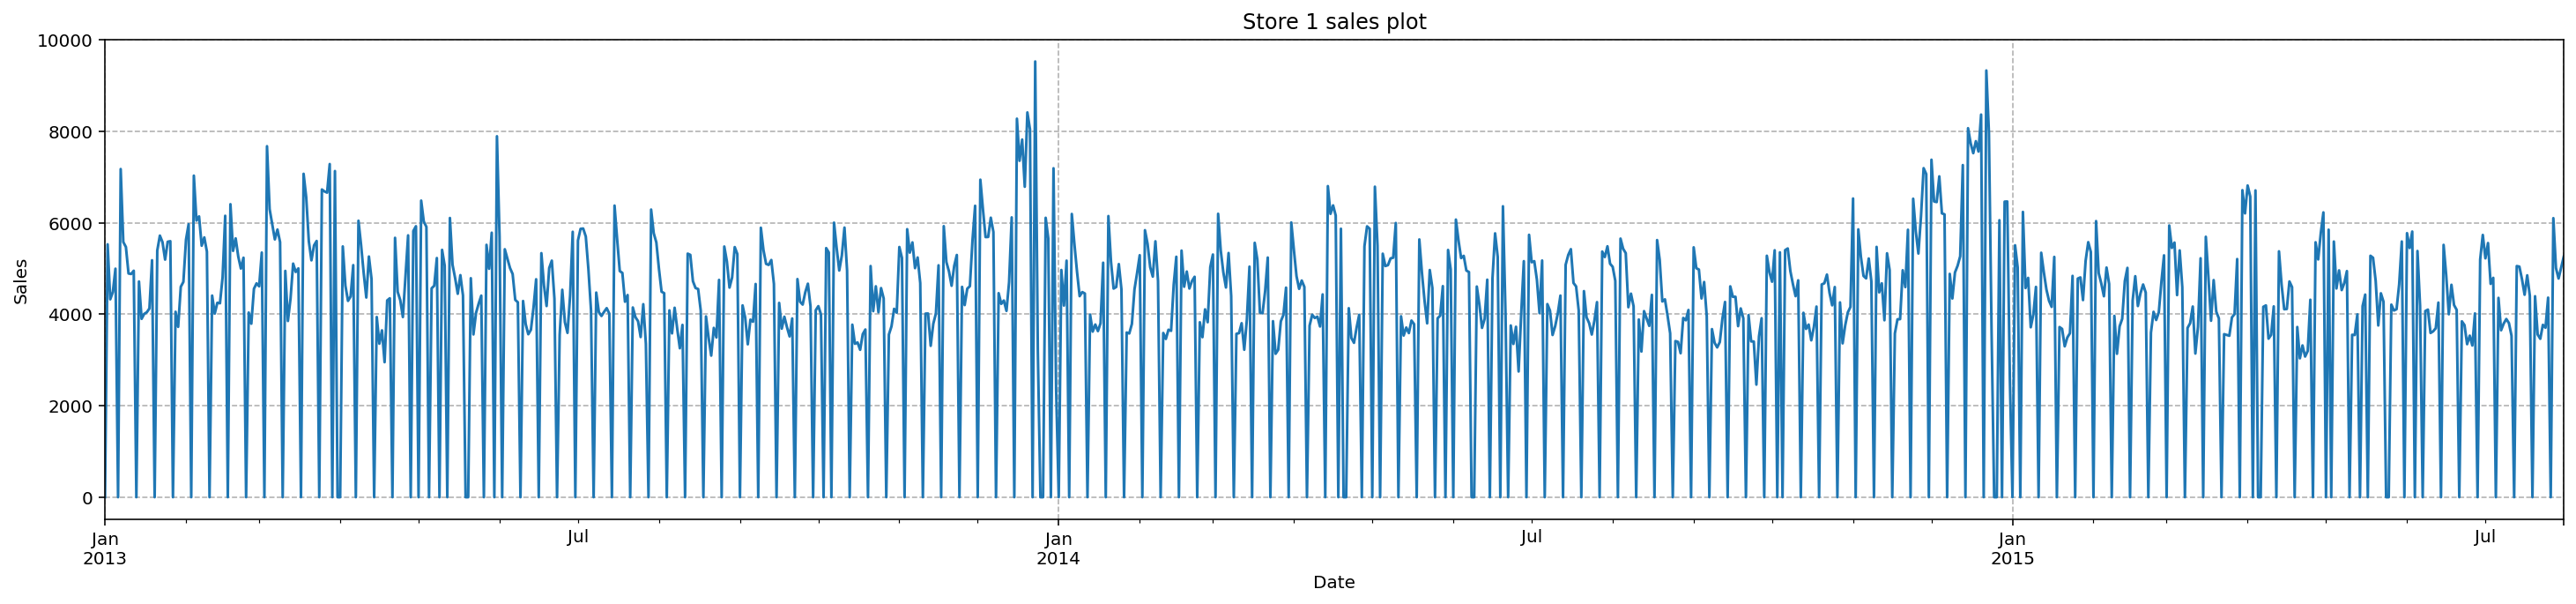

In [26]:
plot_sales(store1_pipeline(sales))

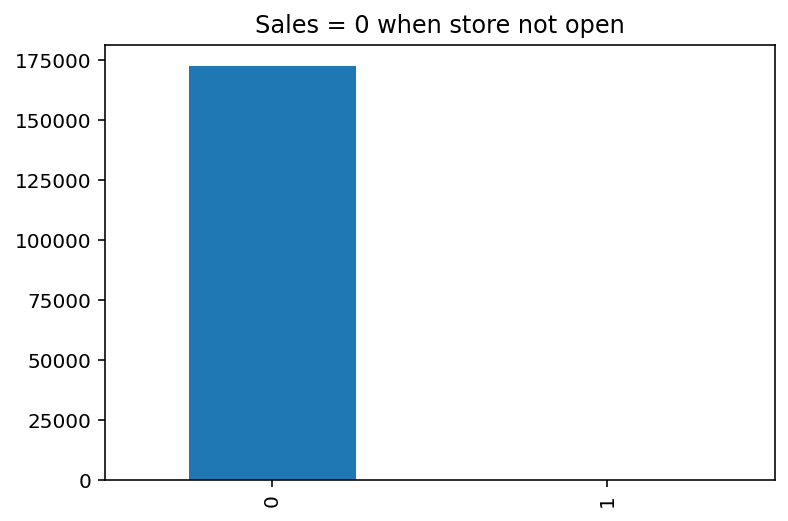

In [21]:
sales[sales.Sales == 0].Open.value_counts().plot(kind = 'bar')
plt.title("Sales = 0 when store not open")
plt.show()

In [22]:
open_store1 = compose(store1_pipeline, filter_open_days)

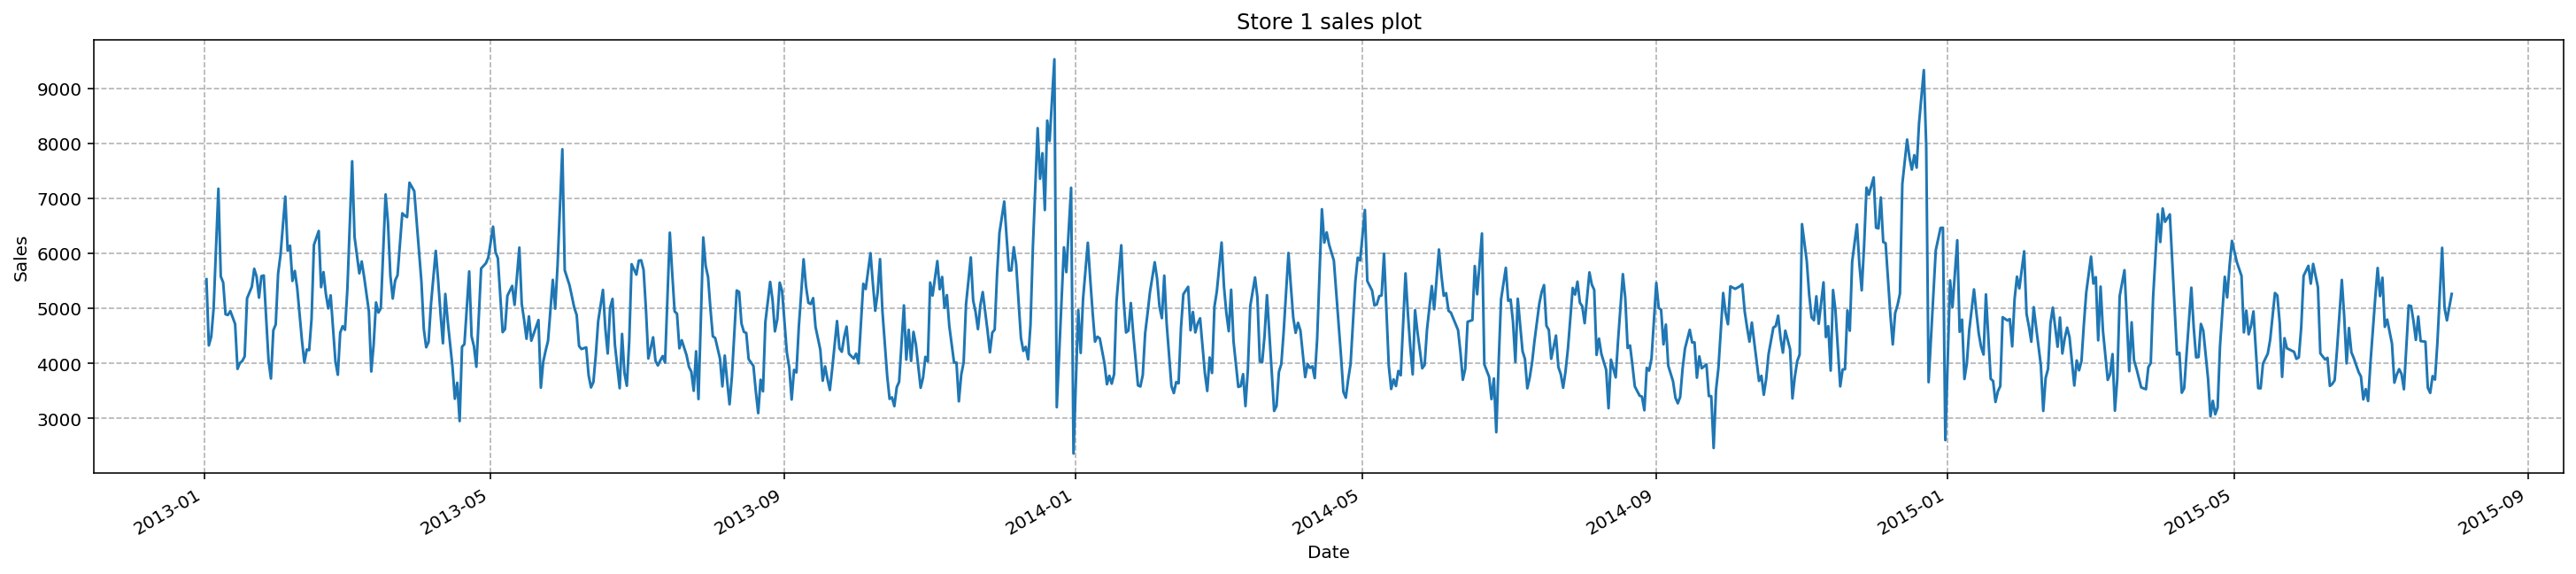

In [23]:
plot_sales(open_store1(sales))

In [28]:
prophet_pipeline = compose(
    store1_pipeline, 
    make_simple_prophet_data()
)

In [29]:
prophet_pipeline(sales)

ds     y
Date                       
2015-07-31 2015-07-31  5263
2015-07-30 2015-07-30  5020
2015-07-29 2015-07-29  4782
2015-07-28 2015-07-28  5011
2015-07-27 2015-07-27  6102
...               ...   ...
2013-01-05 2013-01-05  4997
2013-01-04 2013-01-04  4486
2013-01-03 2013-01-03  4327
2013-01-02 2013-01-02  5530
2013-01-01 2013-01-01     0

[942 rows x 2 columns]

### 就这几行代码，就够预测一个时间序列了

In [30]:
m = Prophet()
m.fit(prophet_pipeline(sales))
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)
clear_output()

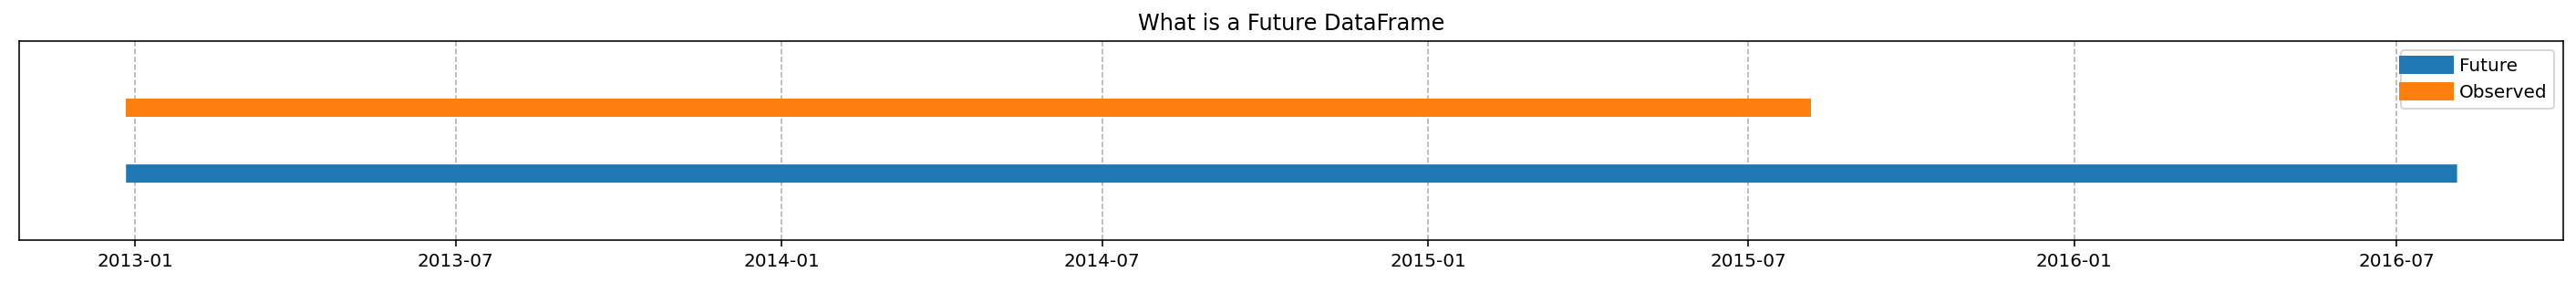

In [33]:
fig, ax = plt.subplots(figsize = (25,2))
plt.plot(future['ds'], np.ones(len(future)), lw = 10, label = 'Future')
plt.plot(
    store1_pipeline(sales)['Date'], 
    2 * np.ones(store1_pipeline(sales).shape[0]), lw = 10, label = 'Observed')

plt.ylim(0,3)
plt.yticks([])
plt.grid(linestyle = '--')
plt.legend(loc = 'upper right')
plt.title("What is a Future DataFrame", fontsize = 12)
plt.show()

**A future dataframe contains past & future,predict要送进去什么东西，prophet已经帮你准备好了**

#### 时间序列画图是一个非常繁琐和费劲的事情，很难统一的做，所以Prophet帮你做好了

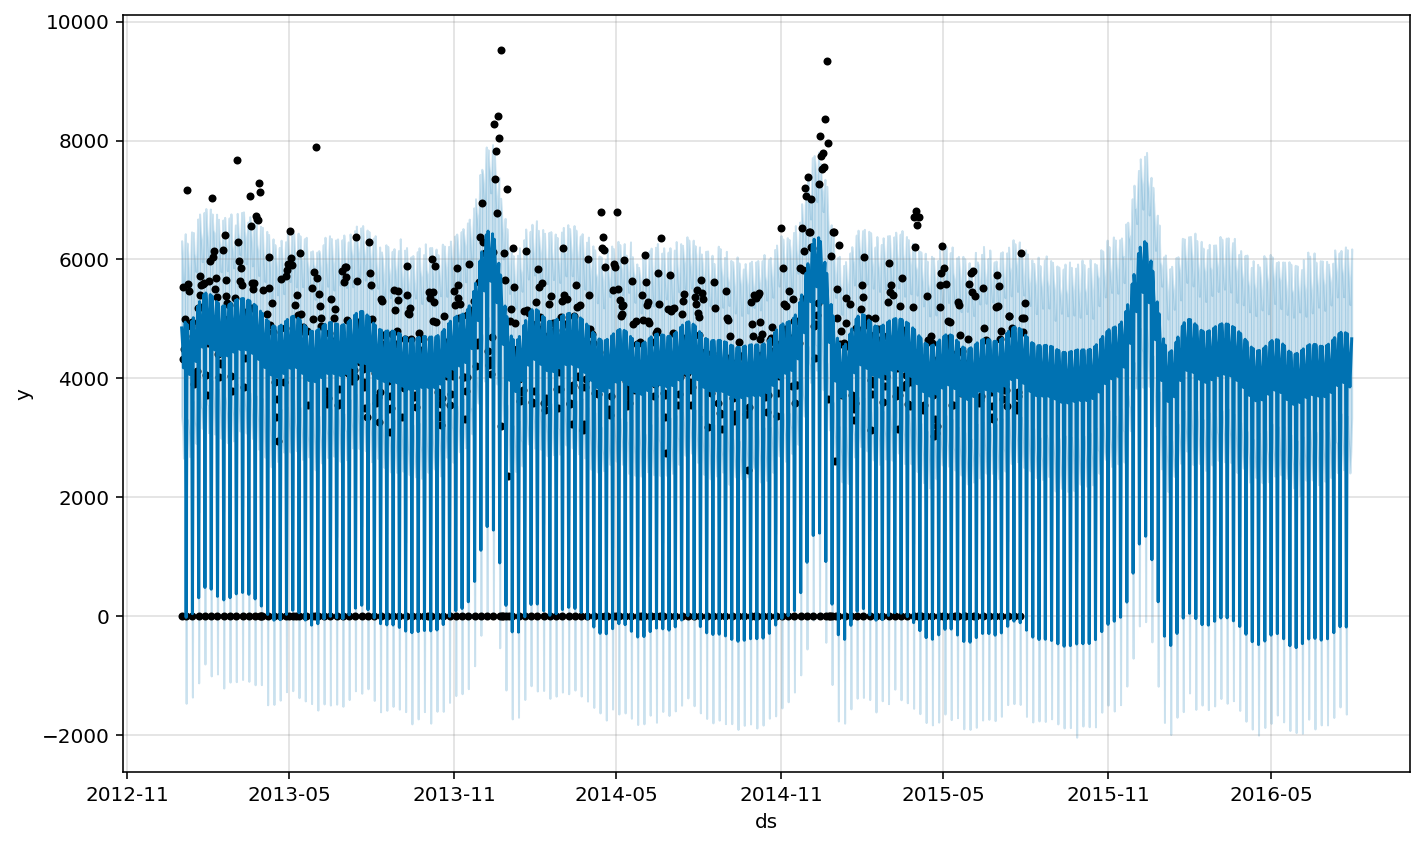

In [29]:
m.plot(forecast)
plt.show()

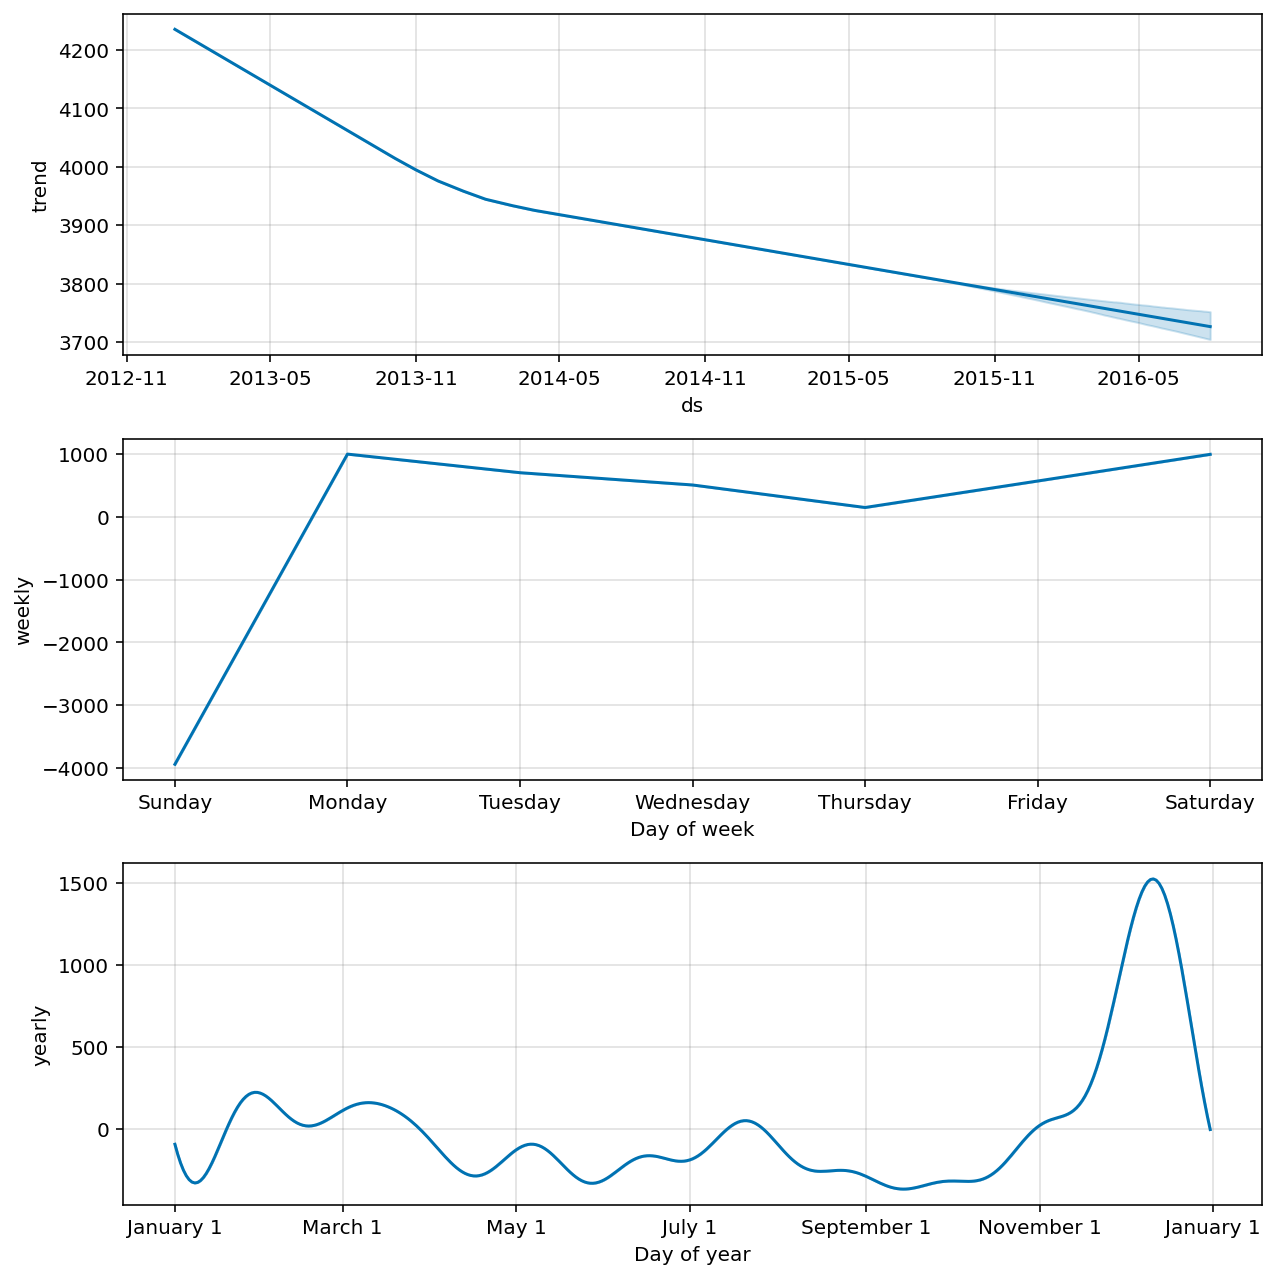

In [34]:
m.plot_components(forecast)
clear_output()
plt.show()

In [36]:
class PipelinedModel:
    
    def __init__(self, pipeline, model = None, test_periods = 365, multivariate = False):
        self.pipeline = pipeline
        self.model = model if model else Prophet()
        self.test_periods = test_periods
        self.multivariate = multivariate

    def make_train(self, data):
        if self.multivariate:
            self.train = self.pipeline(data).sort_index()[:-self.test_periods]
        else:
            self.train = self.pipeline(data)

        print(self.train.ds.min(), self.train.ds.max())
        return self.train

    def make_future(self, data = None, periods = None):
        if self.multivariate:
            self.future =  self.pipeline(data).drop('y', axis = 1).sort_index()
        else:
            periods = periods if periods else self.test_periods
            self.future = self.model.make_future_dataframe(periods = periods)
        return self.future

    def fit(self, data):
        self.model.fit(self.make_train(data))
        self.make_future(data)
        return self
    
    def forecast(self, periods = None):
        periods = periods if periods else self.test_periods
        future = self.future
        return self.model.predict(future)

    def plot(self, periods = None):
        periods = periods if periods else self.test_periods
        return self.model.plot(self.forecast(periods))

    def plot_components(self, periods = None):
        periods = periods if periods else self.test_periods
        return self.model.plot_components(self.forecast(periods))

In [37]:
pm1 = PipelinedModel(prophet_pipeline).fit(sales)
clear_output()

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1542.85    0.00719059        167.77      0.5469           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       1544.06   1.68931e-05       83.4267   1.796e-07       0.001      267  LS failed, Hessian reset 
     197       1544.06   4.65361e-08       79.3941     0.08172           1      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


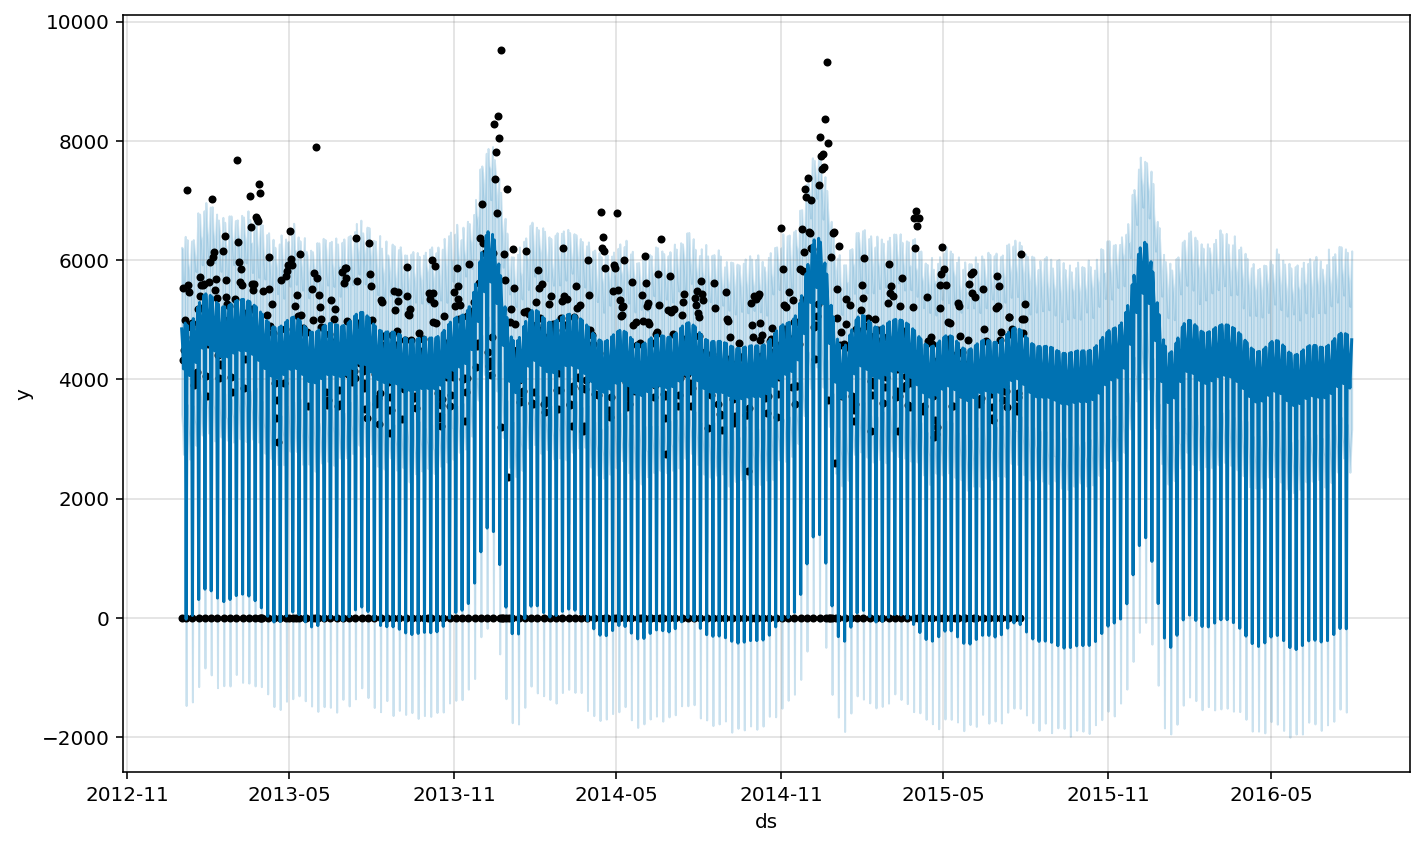

In [38]:
pm1.plot()
clear_output()
plt.show()

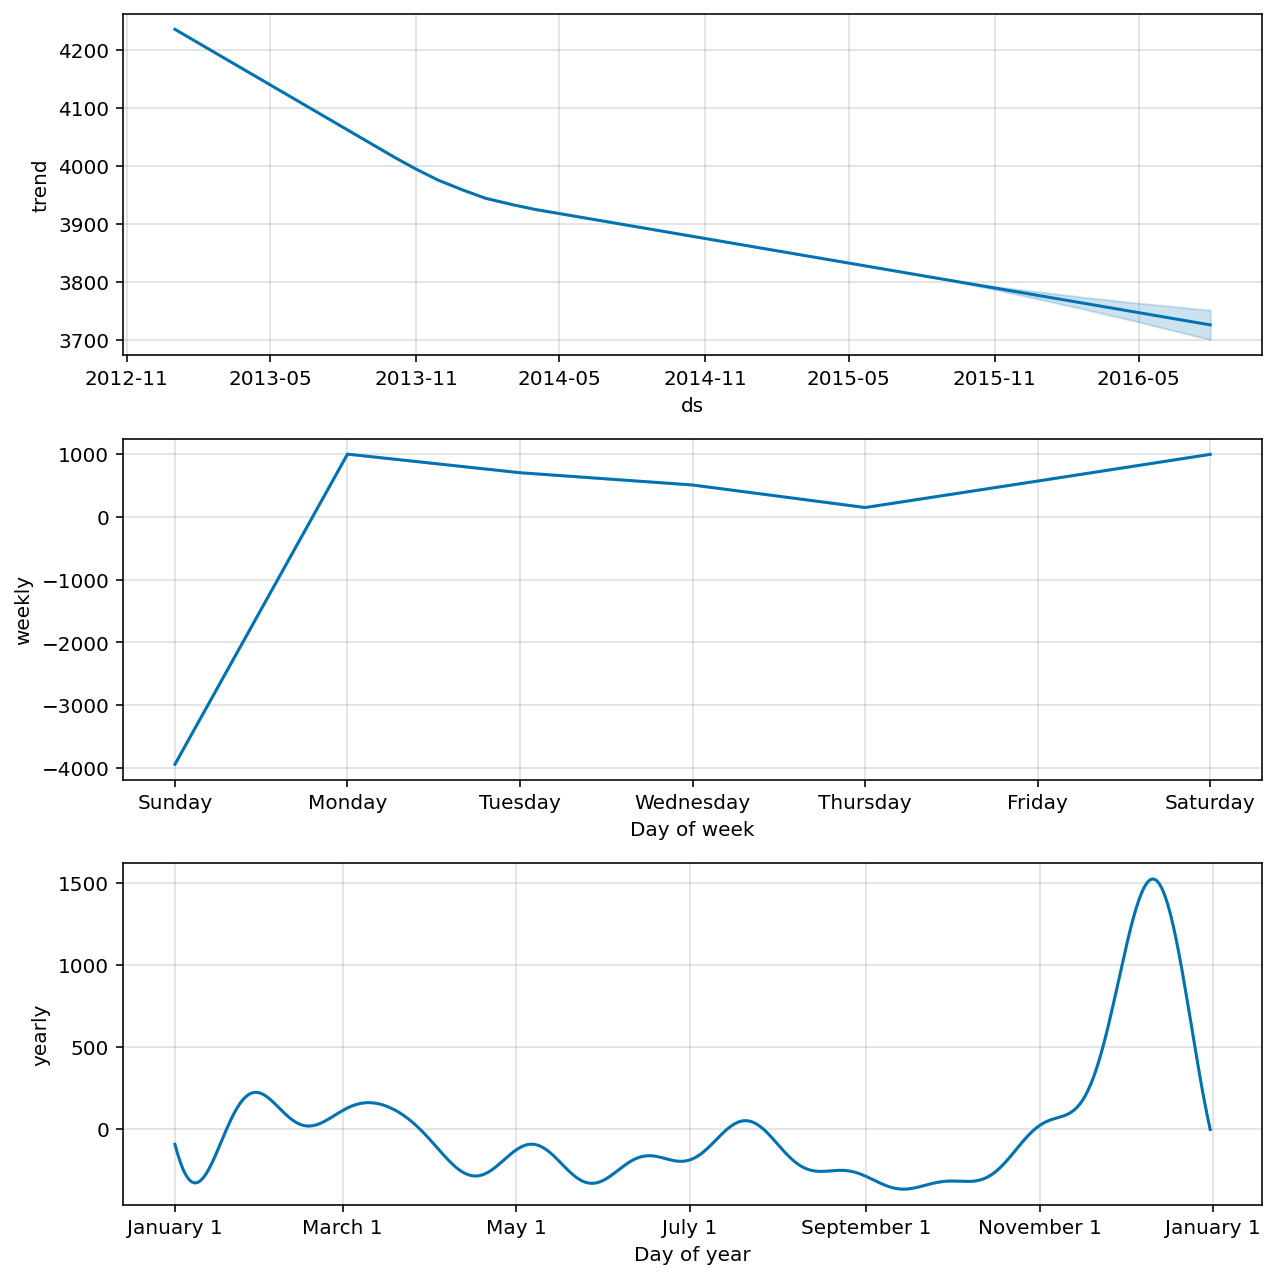

In [39]:
pm1.plot_components()
clear_output()
plt.show()

In [40]:
prophet_clean_pipeline = compose(
    store1_pipeline, 
    filter_open_days, 
    make_simple_prophet_data()
)

In [41]:
pm2 = PipelinedModel(prophet_clean_pipeline).fit(sales)
clear_output()

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1496.8   4.15395e-06       81.6028           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        1496.8   2.30717e-08       65.4622       0.132      0.3458      164   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


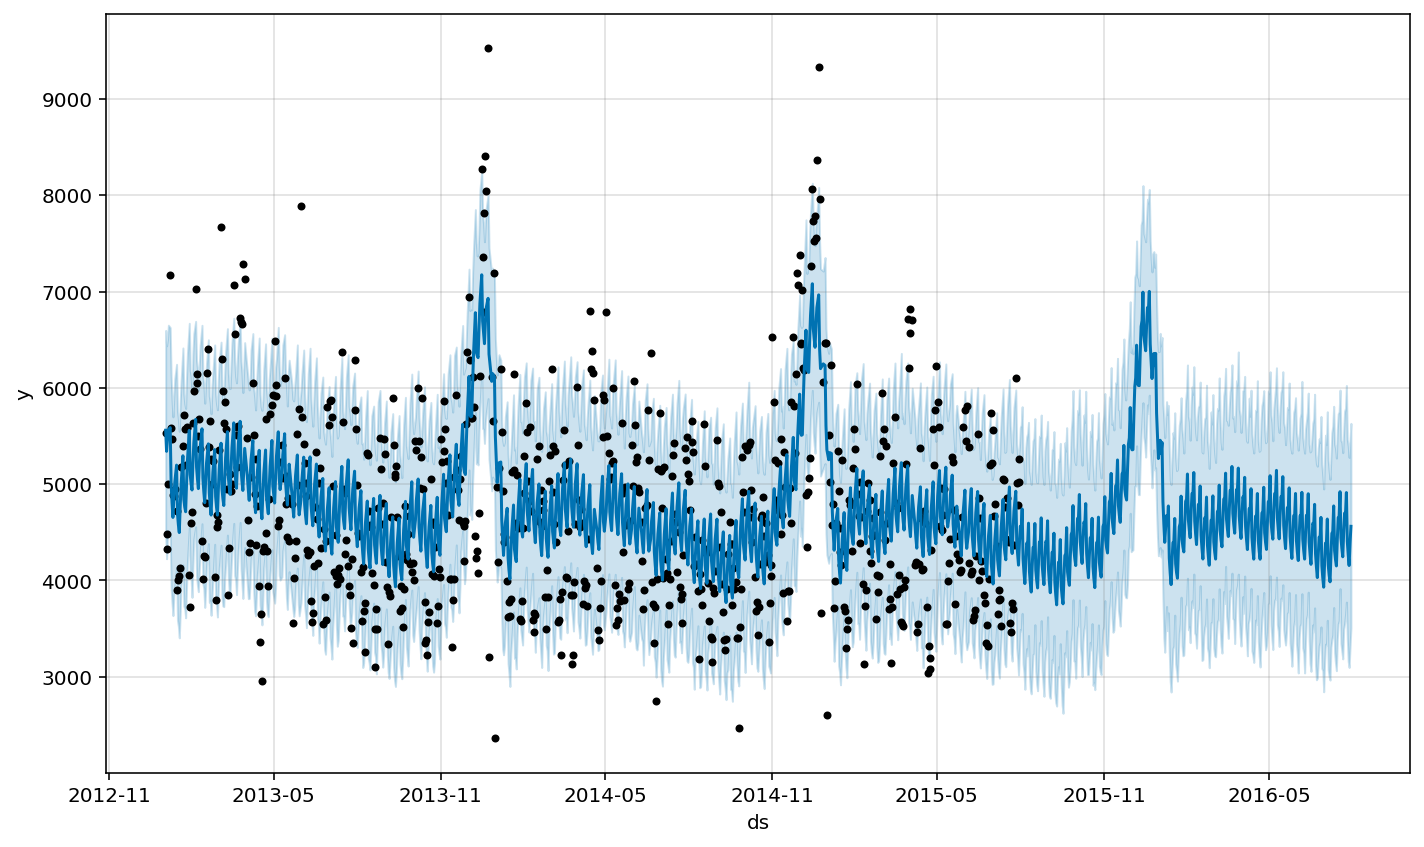

In [42]:
pm2.plot()
clear_output()
plt.show()

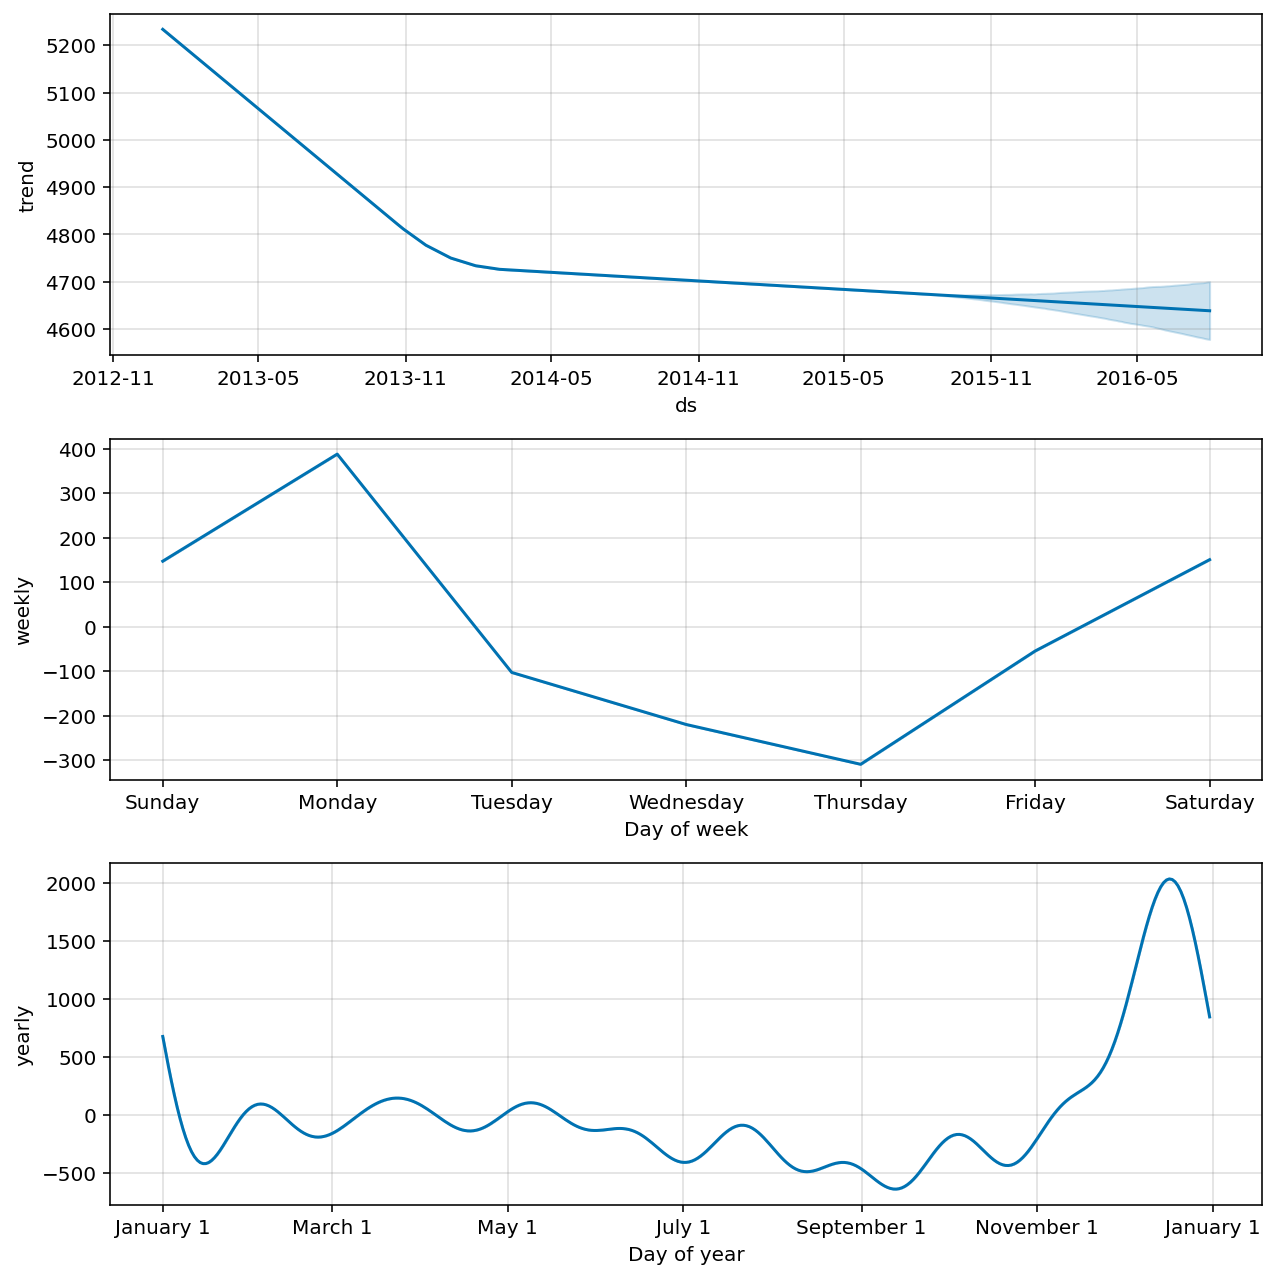

In [43]:
pm2.plot_components()
clear_output()
plt.show()

In [44]:
tmp_model =  Prophet()
tmp_model.add_country_holidays(country_name = "US")

pm3 = PipelinedModel(prophet_clean_pipeline, tmp_model).fit(sales)
clear_output()

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1500.47   2.95817e-05       82.2963       0.535       0.535      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       1500.47   9.24344e-05       72.5389   1.009e-06       0.001      196  LS failed, Hessian reset 
     176       1500.48   2.18945e-06       88.2885   3.749e-08       0.001      303  LS failed, Hessian reset 
     190       1500.48   6.48874e-08       71.4278      0.2177           1      319   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


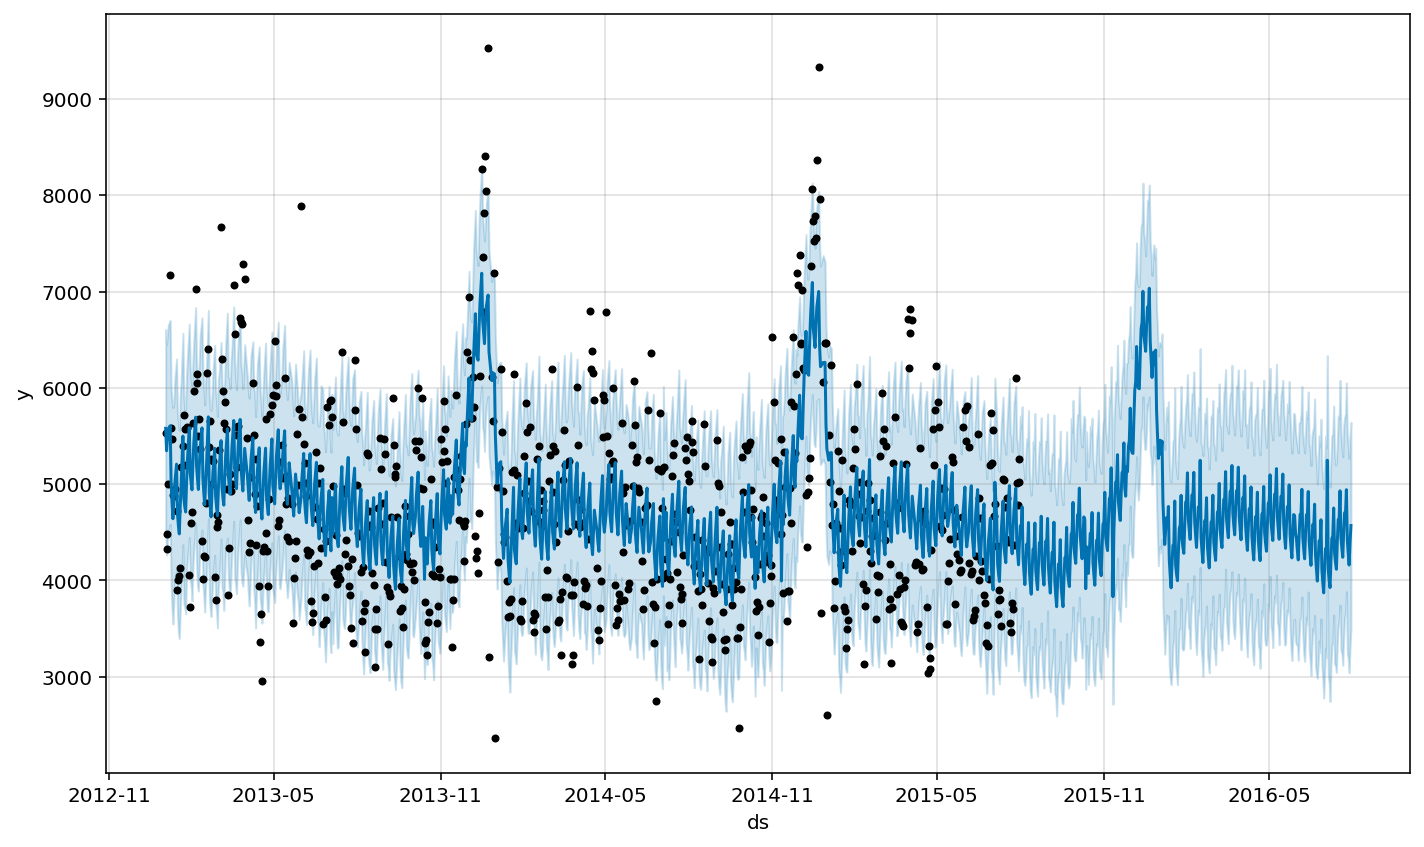

In [45]:
pm3.plot()
clear_output()
plt.show()

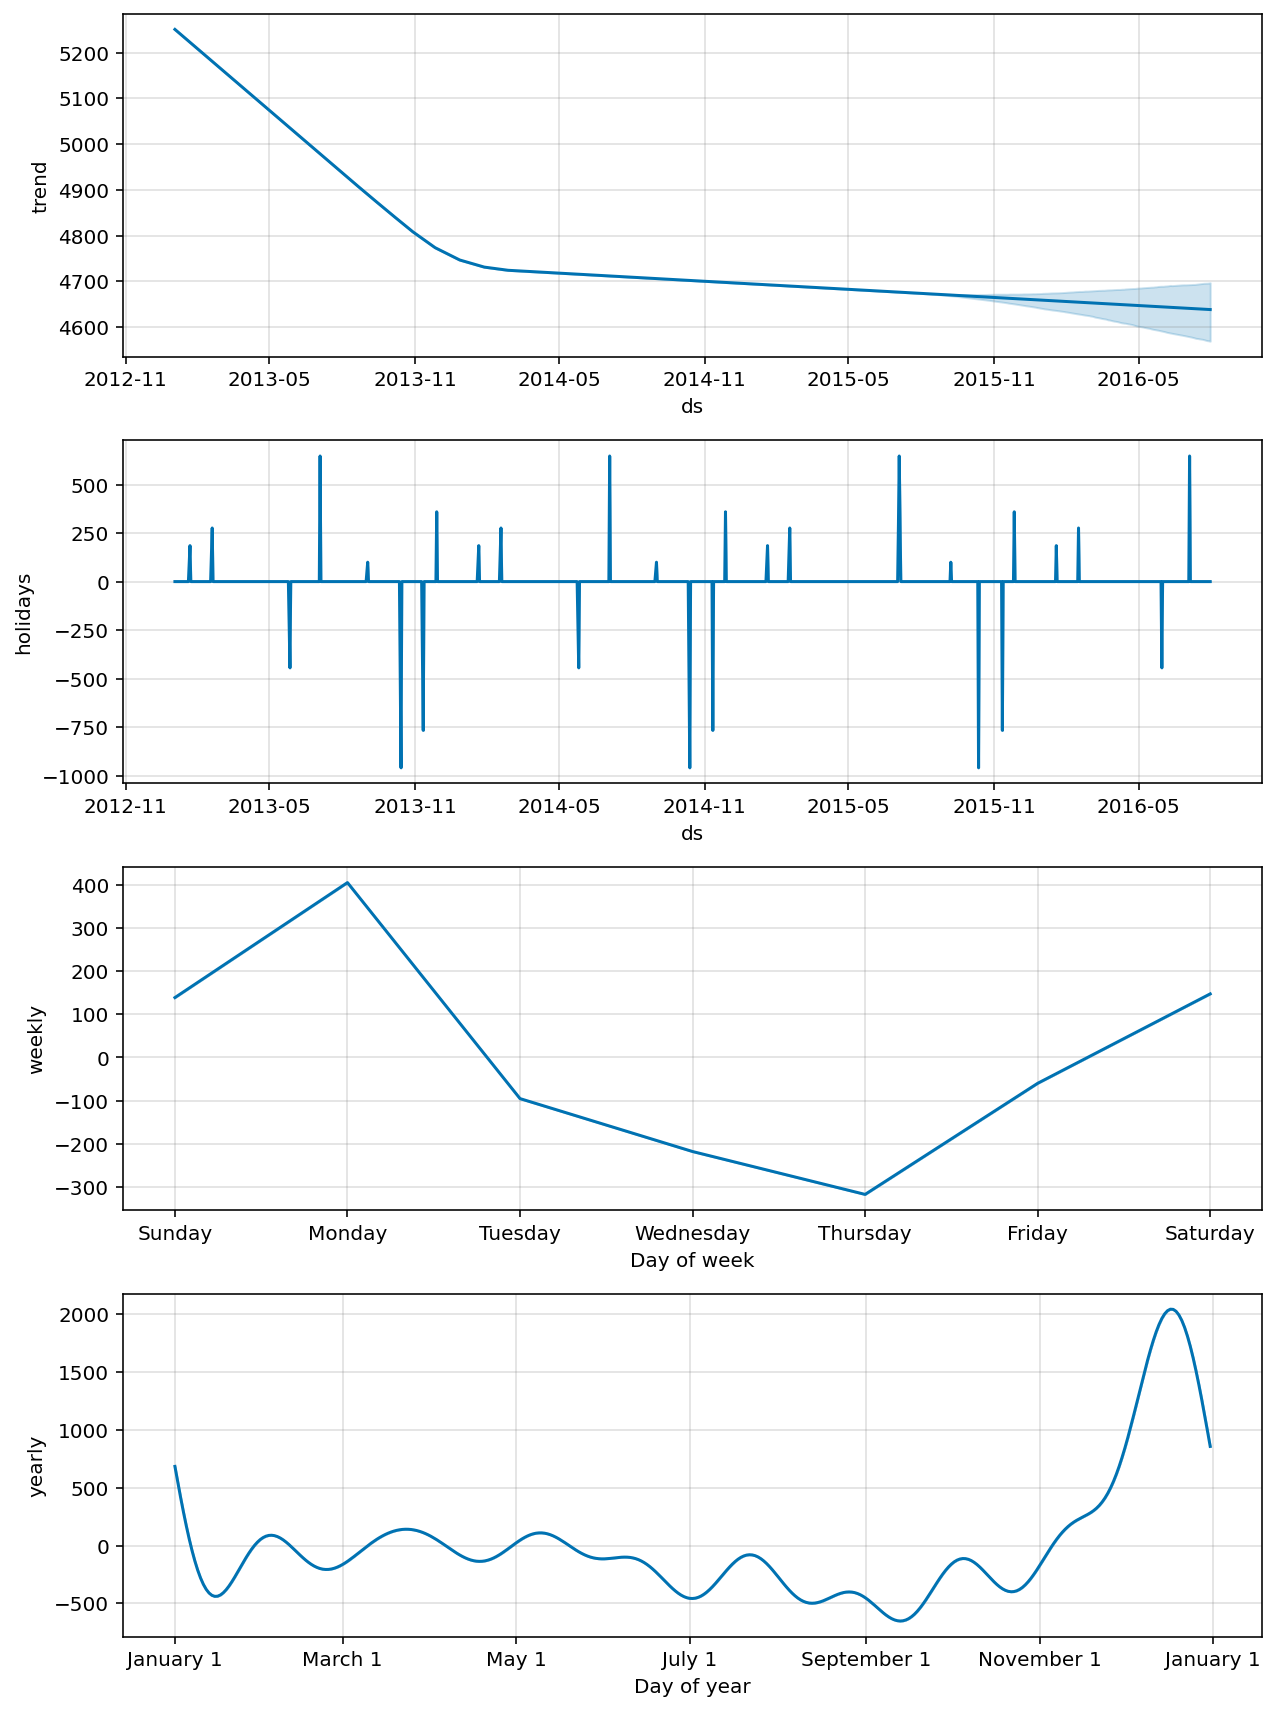

In [46]:
pm3.plot_components()
clear_output()
plt.show()

In [42]:
sales.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
Date                                                                     
2015-07-31      1          5 2015-07-31   5263        555     1      1   
2015-07-31      2          5 2015-07-31   6064        625     1      1   
2015-07-31      3          5 2015-07-31   8314        821     1      1   
2015-07-31      4          5 2015-07-31  13995       1498     1      1   
2015-07-31      5          5 2015-07-31   4822        559     1      1   

           StateHoliday  SchoolHoliday  
Date                                    
2015-07-31            0              1  
2015-07-31            0              1  
2015-07-31            0              1  
2015-07-31            0              1  
2015-07-31            0              1

### Variable Inpect

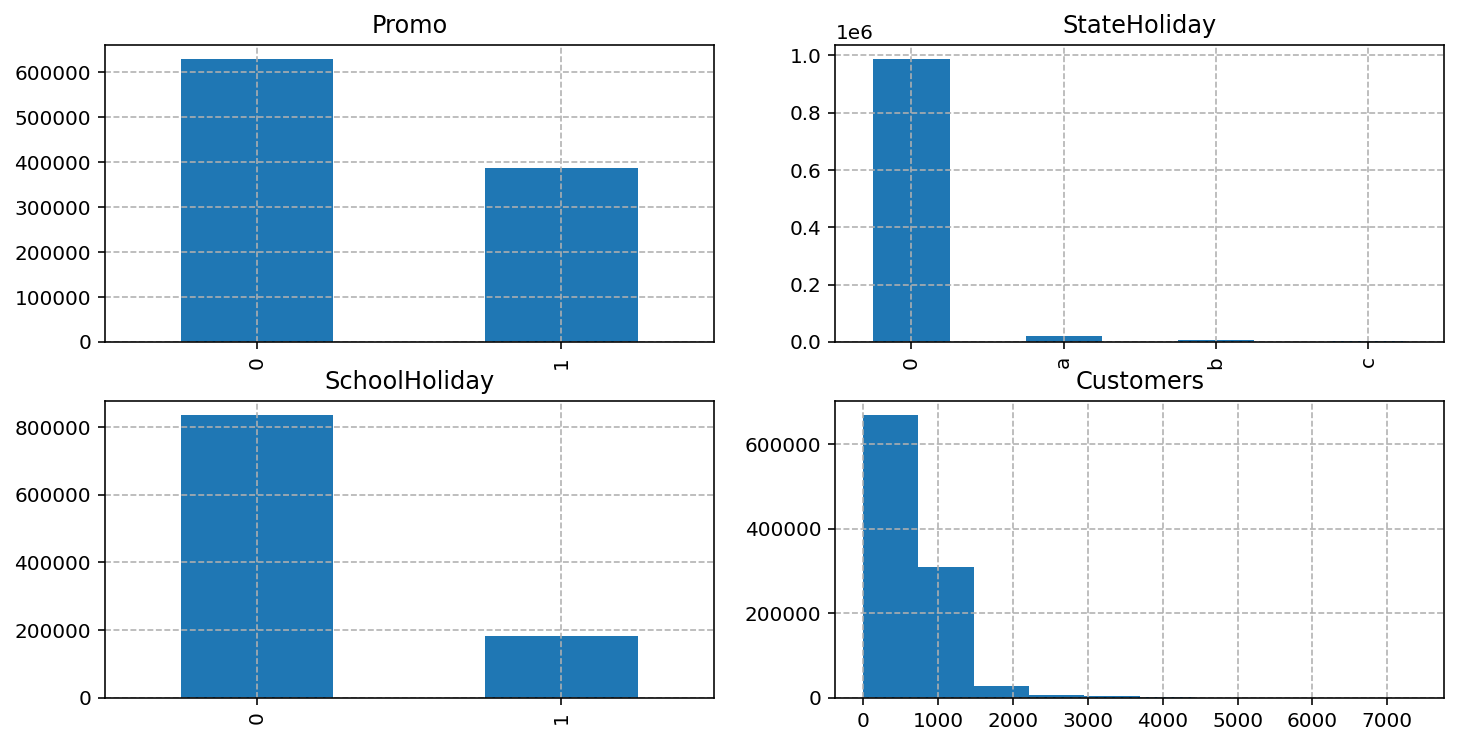

In [43]:
fig, ax = plt.subplots(figsize = (12,6))
plt.subplot(2,2,1)
sales['Promo'].value_counts().plot(kind = 'bar')
plt.title("Promo")
plt.grid(linestyle = '--')
plt.subplot(2,2,2)
sales['StateHoliday'].value_counts().plot(kind = 'bar')
plt.title("StateHoliday")
plt.grid(linestyle = '--')
plt.subplot(2,2,3)
sales['SchoolHoliday'].value_counts().plot(kind = 'bar')
plt.title("SchoolHoliday")
plt.grid(linestyle = '--')
plt.subplot(2,2,4)
sales['Customers'].hist()
plt.title("Customers")
plt.grid(linestyle = '--')
plt.show()

In [48]:
def feature_engineering(df):
    df = df.copy()
    df[['SH1','SH2', 'SH3']] = pd.get_dummies(df['StateHoliday'], drop_first = True).copy()
    return df

def feed_to_prophet_multivariable(ds = 'Date', y = 'Sales', columns = None):
    if columns is None:
        columns = ['ds','y','Promo','SH1','SH2','SH3','SchoolHoliday']
    def _feed_to_prophet_multivariable(df):
        df.rename(columns = {ds:"ds", y:"y"}, inplace = True)
        return df[columns]
    return _feed_to_prophet_multivariable

In [49]:
full_pipeline = compose(
    store1_pipeline, 
    feature_engineering, 
    feed_to_prophet_multivariable('Date', 'Sales', ['ds','y','Promo','SH1','SH2','SH3','SchoolHoliday',"Open"])
    )

full_pipeline(sales)

ds     y  Promo  SH1  SH2  SH3  SchoolHoliday  Open
Date                                                                  
2015-07-31 2015-07-31  5263      1    0    0    0              1     1
2015-07-30 2015-07-30  5020      1    0    0    0              1     1
2015-07-29 2015-07-29  4782      1    0    0    0              1     1
2015-07-28 2015-07-28  5011      1    0    0    0              1     1
2015-07-27 2015-07-27  6102      1    0    0    0              1     1
...               ...   ...    ...  ...  ...  ...            ...   ...
2013-01-05 2013-01-05  4997      0    0    0    0              1     1
2013-01-04 2013-01-04  4486      0    0    0    0              1     1
2013-01-03 2013-01-03  4327      0    0    0    0              1     1
2013-01-02 2013-01-02  5530      0    0    0    0              1     1
2013-01-01 2013-01-01     0      0    1    0    0              1     0

[942 rows x 8 columns]

In [50]:
full_pipeline = compose(
    store1_pipeline, 
    feature_engineering, 
    feed_to_prophet_multivariable('Date', 'Sales', ['ds','y','Promo','SH1','SH2','SH3','SchoolHoliday',"Open"])
    )

def create_model():
    tmpmodel = Prophet()
    tmpmodel.add_regressor('Open', mode = 'multiplicative')
    tmpmodel.add_regressor('Promo', mode = 'additive')
    tmpmodel.add_regressor('SH1', mode = 'additive')
    tmpmodel.add_regressor('SH2', mode = 'additive')
    tmpmodel.add_regressor('SH3', mode = 'additive')
    tmpmodel.add_regressor('SchoolHoliday', mode = 'additive')
    return tmpmodel

pm4 = PipelinedModel(
    full_pipeline, 
    create_model(), 
    test_periods = 365,
    multivariate=True)

pm4.fit(sales)
clear_output()

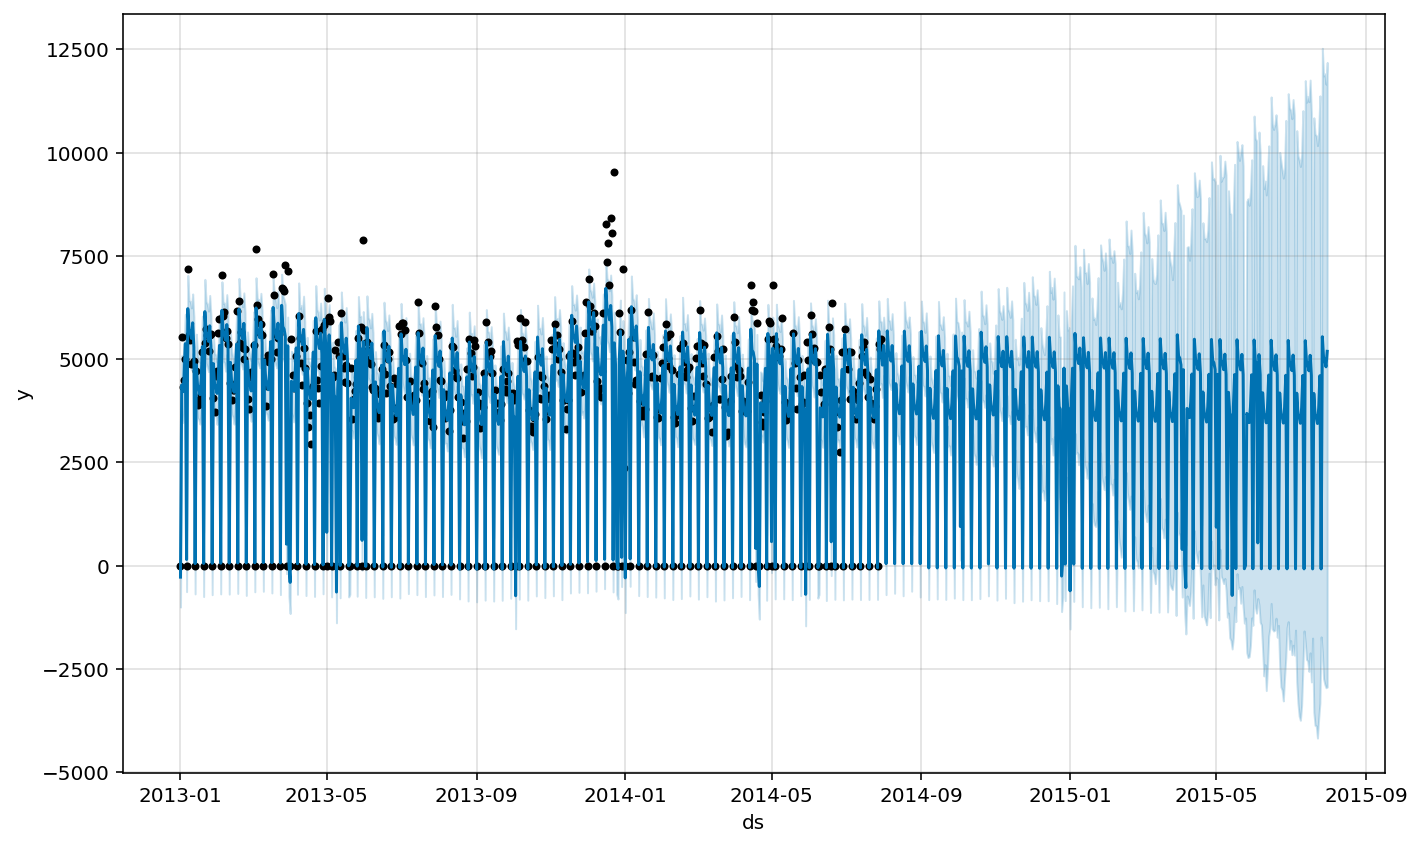

In [51]:
pm4.plot()
clear_output()
plt.show()

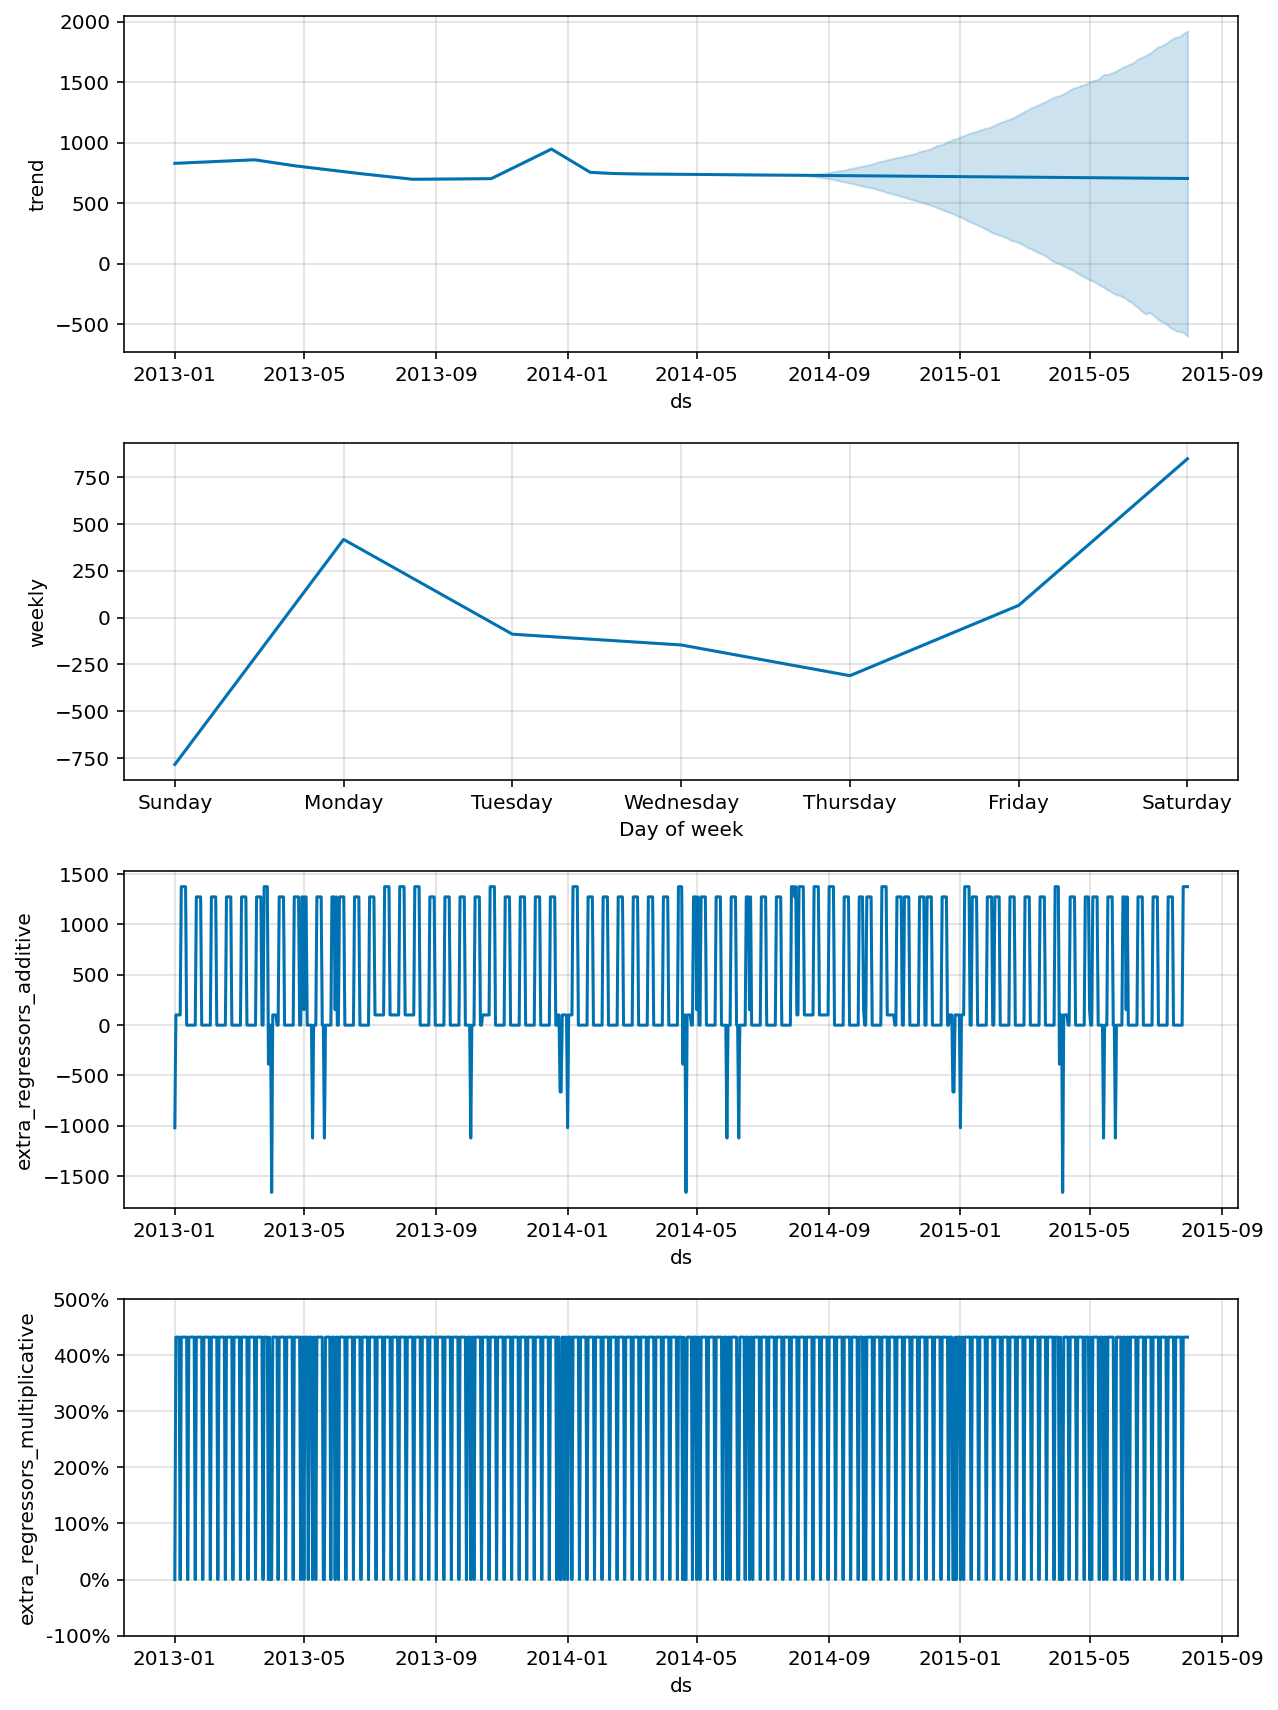

In [47]:
pm4.plot_components()
clear_output()
plt.show()

In [ ]:
Talib

#### 可能出现的Bug

In [52]:
pm4 = PipelinedModel(full_pipeline, create_model()).fit(sales)
clear_output()

      69.154           1           1      605   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429        2144.7   6.98289e-06       75.2776    8.87e-08       0.001      687  LS failed, Hessian reset 
     442        2144.7   5.47674e-08       64.4024     0.03556      0.6583      706   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [53]:
try:
    pm4.plot_components()
except Exception as e:
    print("Got Error: " ,e)

Got Error:  Regressor 'Open' missing from dataframe


**Got an error on future_dataframe, <font color = 'darkcyan'>we don't have feature on out-of-sample period</font>**

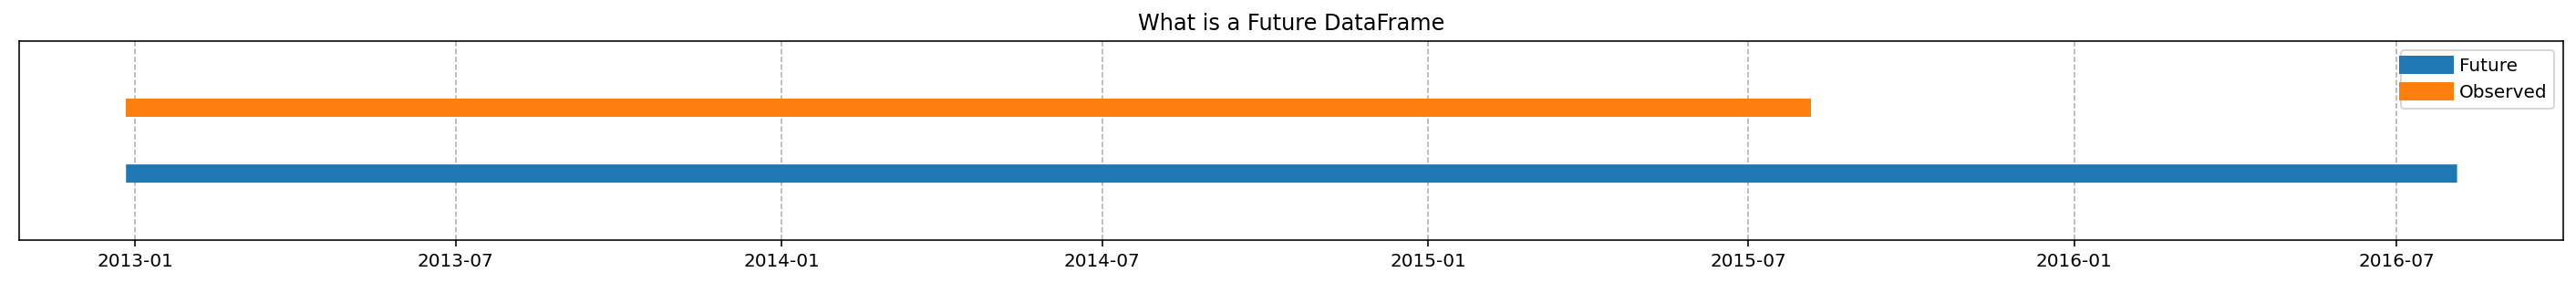

In [54]:
fig, ax = plt.subplots(figsize = (25,2))
plt.plot(future['ds'], np.ones(len(future)), lw = 10, label = 'Future')
plt.plot(
    store1_pipeline(sales)['Date'], 
    2 * np.ones(store1_pipeline(sales).shape[0]), lw = 10, label = 'Observed')

plt.ylim(0,3)
plt.yticks([])
plt.grid(linestyle = '--')
plt.legend(loc = 'upper right')
plt.title("What is a Future DataFrame", fontsize = 12)
plt.show()

### Code Refactor - 自己想办法构建Future

In [55]:
def train_test_split(pipeline, periods = 365):
    df = pipeline(sales).sort_index()
    train = df[:-365]
    test = df[-365:]
    return train, test

full_pipeline = compose(
    store1_pipeline, 
    feature_engineering, 
    feed_to_prophet_multivariable('Date', 'Sales', ['ds','y','Promo','SH1','SH2','SH3','SchoolHoliday',"Open"])
    )

sales_df = full_pipeline(sales)
train,test = train_test_split(full_pipeline)

mm = Prophet()
mm.add_regressor('Open', mode = 'multiplicative')
mm.add_regressor('Promo', mode = 'additive')
mm.add_regressor('SH1', mode = 'additive')
mm.add_regressor('SH2', mode = 'additive')
mm.add_regressor('SH3', mode = 'additive')
mm.add_regressor('SchoolHoliday', mode = 'additive')
_ = mm.fit(train)

forecast = mm.predict(sales_df.drop('y', axis = 1).sort_index())

clear_output()

In [56]:
sales_df

ds     y  Promo  SH1  SH2  SH3  SchoolHoliday  Open
Date                                                                  
2015-07-31 2015-07-31  5263      1    0    0    0              1     1
2015-07-30 2015-07-30  5020      1    0    0    0              1     1
2015-07-29 2015-07-29  4782      1    0    0    0              1     1
2015-07-28 2015-07-28  5011      1    0    0    0              1     1
2015-07-27 2015-07-27  6102      1    0    0    0              1     1
...               ...   ...    ...  ...  ...  ...            ...   ...
2013-01-05 2013-01-05  4997      0    0    0    0              1     1
2013-01-04 2013-01-04  4486      0    0    0    0              1     1
2013-01-03 2013-01-03  4327      0    0    0    0              1     1
2013-01-02 2013-01-02  5530      0    0    0    0              1     1
2013-01-01 2013-01-01     0      0    1    0    0              1     0

[942 rows x 8 columns]

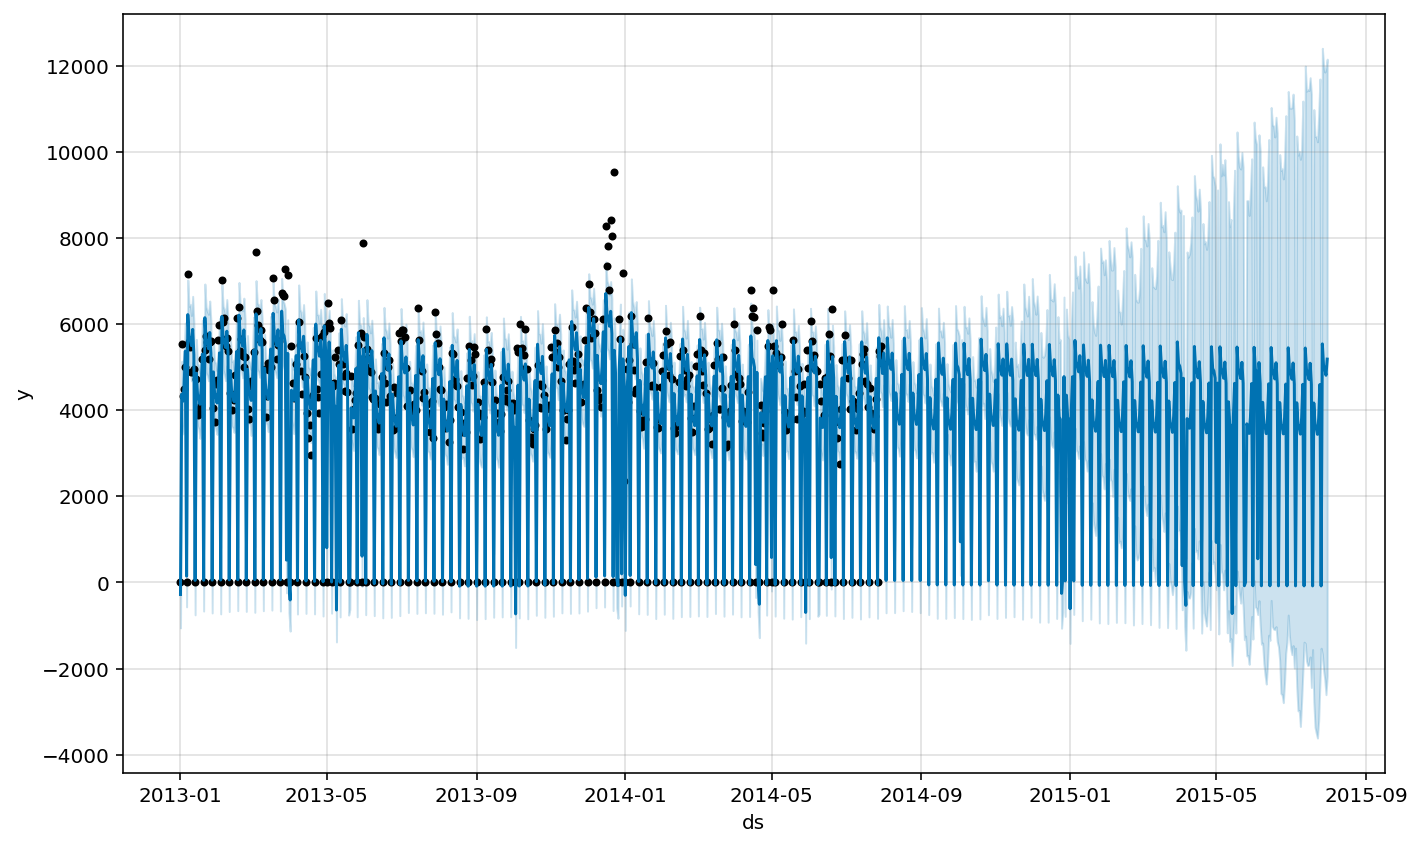

In [57]:
mm.plot(forecast)
plt.show()

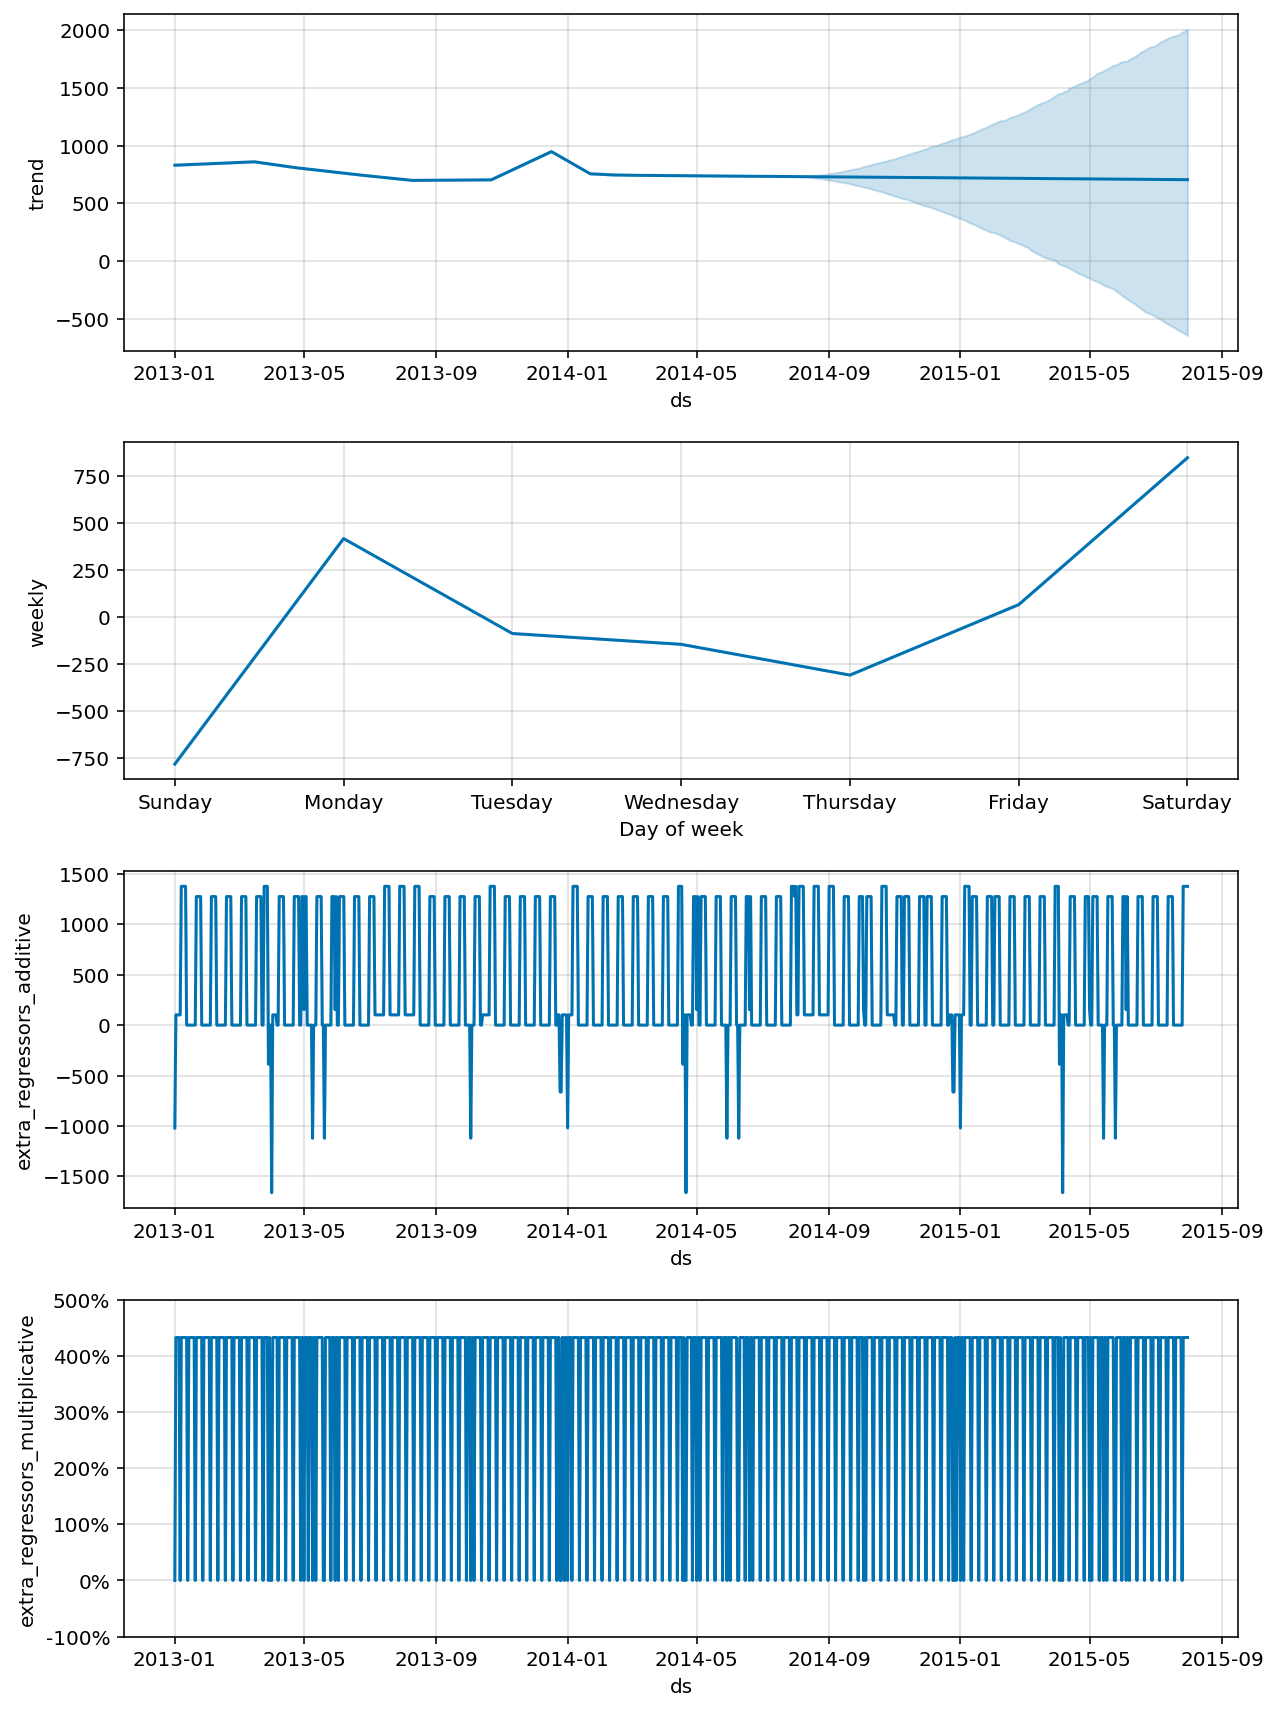

In [54]:
mm.plot_components(forecast)
clear_output()
plt.show()


### Now we have 4 models

In [59]:
pm1.model, pm2.model, pm3.model, pm4.model

(<prophet.forecaster.Prophet at 0x7f9a7fcce7c0>,
 <prophet.forecaster.Prophet at 0x7f9a820bce80>)

In [61]:
from prophet.diagnostics import cross_validation

### Walk Forward Validation

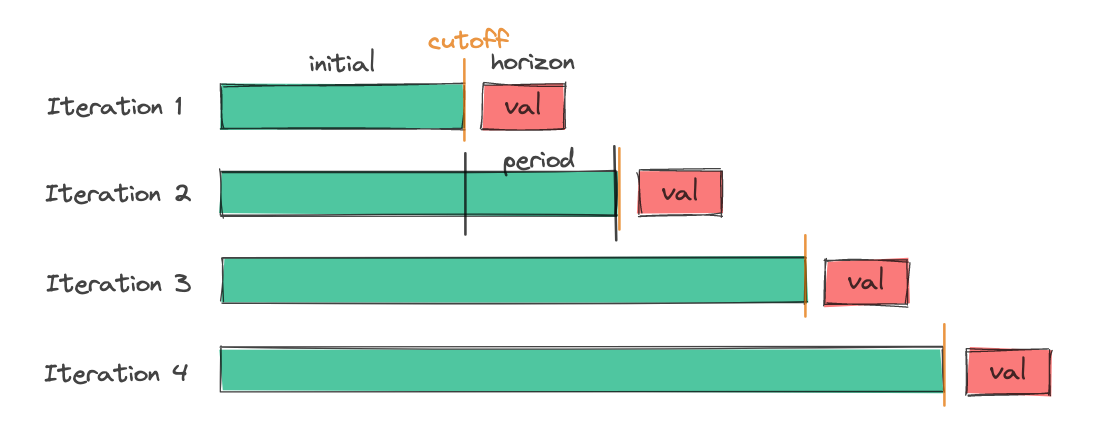

In [62]:
# initial, initial training points
# period step size
# horizon, number of steps to forecast
cv_df = cross_validation(
    pm1.model, 
    initial = "730 days", 
    period = '30 days', 
    horizon = '60 days', 
    disable_tqdm= False)
clear_output()

In [63]:
# cutoff - 从哪一天预测过来的
# ds 预测的是哪一天
# y 观测数据
# yhat 预测数据
# yhat_lower, yhat_upper 预测数据的上下限
cv_df

ds         yhat   yhat_lower   yhat_upper     y     cutoff
0   2015-01-03  4617.439005  3162.659262  6070.077914  5023 2015-01-02
1   2015-01-04  -435.280859 -1917.561139   969.007351     0 2015-01-02
2   2015-01-05  4582.551056  3176.697605  6059.080280  6239 2015-01-02
3   2015-01-06  4199.481135  2672.651185  5628.121460  4574 2015-01-02
4   2015-01-07  3962.672042  2520.322082  5462.845366  4796 2015-01-02
..         ...          ...          ...          ...   ...        ...
355 2015-07-27  4777.053727  3260.281965  6224.968356  6102 2015-06-01
356 2015-07-28  4452.410348  2953.591542  5851.200418  5011 2015-06-01
357 2015-07-29  4237.801556  2731.388481  5522.842940  4782 2015-06-01
358 2015-07-30  3862.202614  2389.500842  5362.105478  5020 2015-06-01
359 2015-07-31  4254.298993  2801.018963  5626.146885  5263 2015-06-01

[360 rows x 6 columns]

In [65]:
from prophet.diagnostics import performance_metrics


p_metric = performance_metrics(cv_df)
p_metric

INFO:prophet:Skipping MAPE because y close to 0


horizon           mse         rmse          mae     mdape     smape  \
0   6 days  2.221036e+06  1490.314090   916.549666  0.136786  0.549683   
1   7 days  1.584931e+06  1258.940418   755.834731  0.131188  0.491100   
2   8 days  1.459901e+06  1208.263829   702.403204  0.122341  0.485572   
3   9 days  1.167266e+06  1080.401047   687.844823  0.144221  0.453405   
4  10 days  5.054647e+05   710.960399   576.953174  0.155477  0.460048   
5  11 days  4.969644e+05   704.957027   568.114279  0.147601  0.403296   
6  12 days  8.601585e+05   927.447298   632.363425  0.147601  0.450124   
7  13 days  8.288930e+05   910.435629   603.832336  0.132334  0.441434   
8  14 days  7.850470e+05   886.028776   566.715355  0.119944  0.433028   
9  15 days  6.566651e+05   810.348751   496.892157  0.102941  0.414326   
10 16 days  5.846936e+05   764.652633   431.119009  0.091776  0.398537   
11 17 days  6.565752e+05   810.293251   486.692561  0.102941  0.464413   
12 18 days  3.212398e+05   566.780180   453.858565  0.108834  0.372106   
13 19 days  3.968182e+05   629.935079   499.511022  0.134537  0.386720   
14 20 days  4.802837e+05   693.025055   568.611605  0.171379  0.402558   
15 21 days  5.358119e+05   731.991753   594.899816  0.188197  0.413073   
16 22 days  6.511954e+05   806.966800   683.534627  0.225892  0.433959   
17 23 days  1.154440e+06  1074.448483   747.216281  0.226240  0.477630   
18 24 days  1.084673e+06  1041.476562   699.139271  0.209451  0.519640   
19 25 days  1.036346e+06  1018.010772   675.985471  0.183116  0.456725   
20 26 days  9.654408e+05   982.568481   623.296122  0.162462  0.445066   
21 27 days  1.050226e+06  1024.805479   658.133505  0.157688  0.444002   
22 28 days  1.204565e+06  1097.526624   707.239684  0.157688  0.449454   
23 29 days  1.375050e+06  1172.625374   791.476953  0.157688  0.461394   
24 30 days  1.655528e+06  1286.673282   920.995666  0.178344  0.485565   
25 31 days  2.350348e+06  1533.084450  1122.843318  0.218860  0.609521   
26 32 days  2.525371e+06  1589.141441  1201.682635  0.225036  0.567473   
27 33 days  2.727259e+06  1651.441434  1186.065014  0.218860  0.601114   
28 34 days  3.154625e+06  1776.126494  1222.101989  0.218860  0.637554   
29 35 days  2.396080e+06  1547.927760  1006.198523  0.156980  0.567889   
30 36 days  2.171014e+06  1473.435982   904.267094  0.133942  0.549543   
31 37 days  1.479767e+06  1216.456899   709.581272  0.118667  0.483049   
32 38 days  1.327707e+06  1152.261766   644.655876  0.118667  0.528005   
33 39 days  1.111279e+06  1054.172168   665.586269  0.128295  0.450556   
34 40 days  5.163336e+05   718.563585   574.540224  0.136036  0.407711   
35 41 days  5.211947e+05   721.938147   575.611540  0.137713  0.407731   
36 42 days  8.777832e+05   936.900845   628.867588  0.131963  0.451612   
37 43 days  8.499709e+05   921.938656   603.894844  0.125725  0.442774   
38 44 days  8.203853e+05   905.751220   583.312805  0.123329  0.437860   
39 45 days  6.933185e+05   832.657476   515.202201  0.102274  0.472728   
40 46 days  5.921904e+05   769.539069   437.584097  0.093442  0.399236   
41 47 days  6.316611e+05   794.771110   480.139091  0.095257  0.407419   
42 48 days  2.661917e+05   515.937725   424.540027  0.099616  0.365050   
43 49 days  3.085724e+05   555.492893   449.777288  0.105067  0.374412   
44 50 days  4.035295e+05   635.239728   514.282975  0.116076  0.389138   
45 51 days  4.542730e+05   673.997787   539.546044  0.148974  0.399008   
46 52 days  5.719247e+05   756.257015   623.291375  0.220908  0.474312   
47 53 days  1.156578e+06  1075.443347   732.715634  0.230743  0.473892   
48 54 days  1.111747e+06  1054.394048   710.799494  0.199556  0.468021   
49 55 days  1.090779e+06  1044.403680   699.697992  0.199556  0.463878   
50 56 days  1.043840e+06  1021.684647   664.633285  0.167626  0.454938   
51 57 days  1.107313e+06  1052.289580   686.762295  0.158343  0.450840   
52 58 days  1.235191e+06  1111.391524   724.596816  0.158343  0.453650   
53 59 d

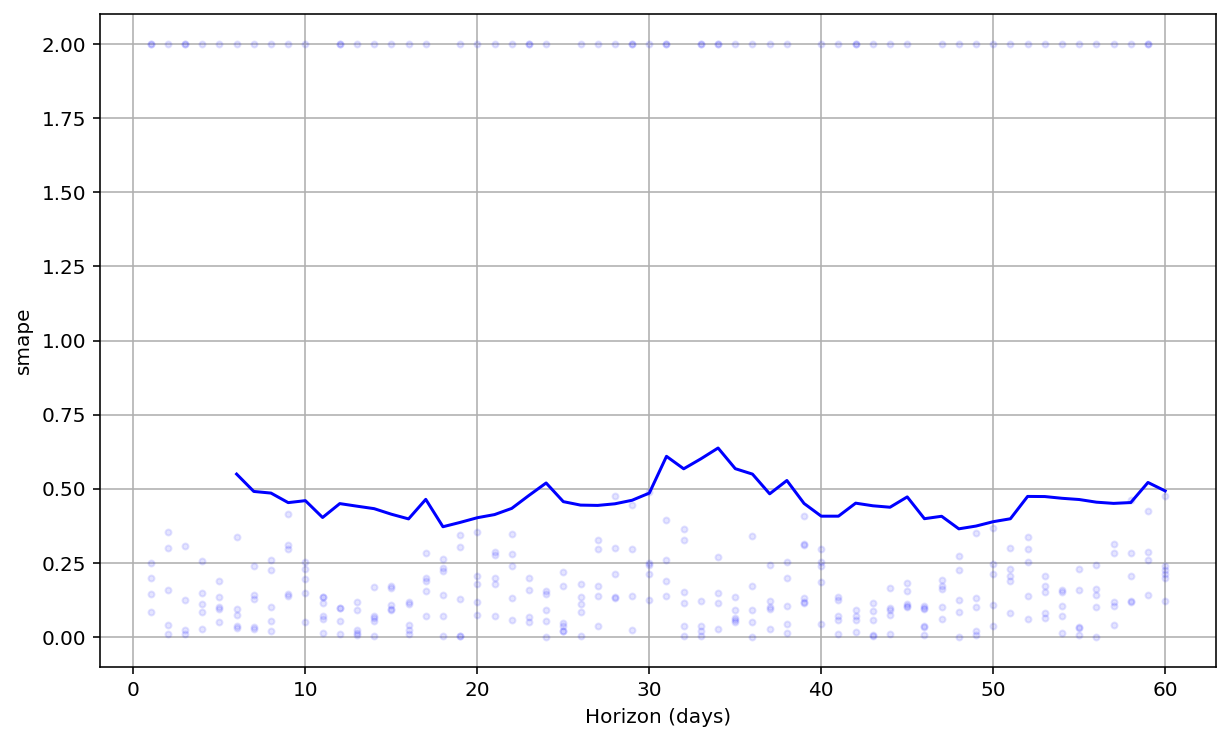

In [66]:
from prophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(cv_df, metric = 'smape')
plt.show()

In [67]:
cross_validation_results = {}
for i, model in enumerate([pm1.model, pm2.model, pm3.model]):
    cross_validation_results[f"model_{i}"] = \
        cross_validation(
            model, 
            initial = "730 days", 
            period = '30 days', 
            horizon = '60 days', 
            disable_tqdm= False
        )
    clear_output()

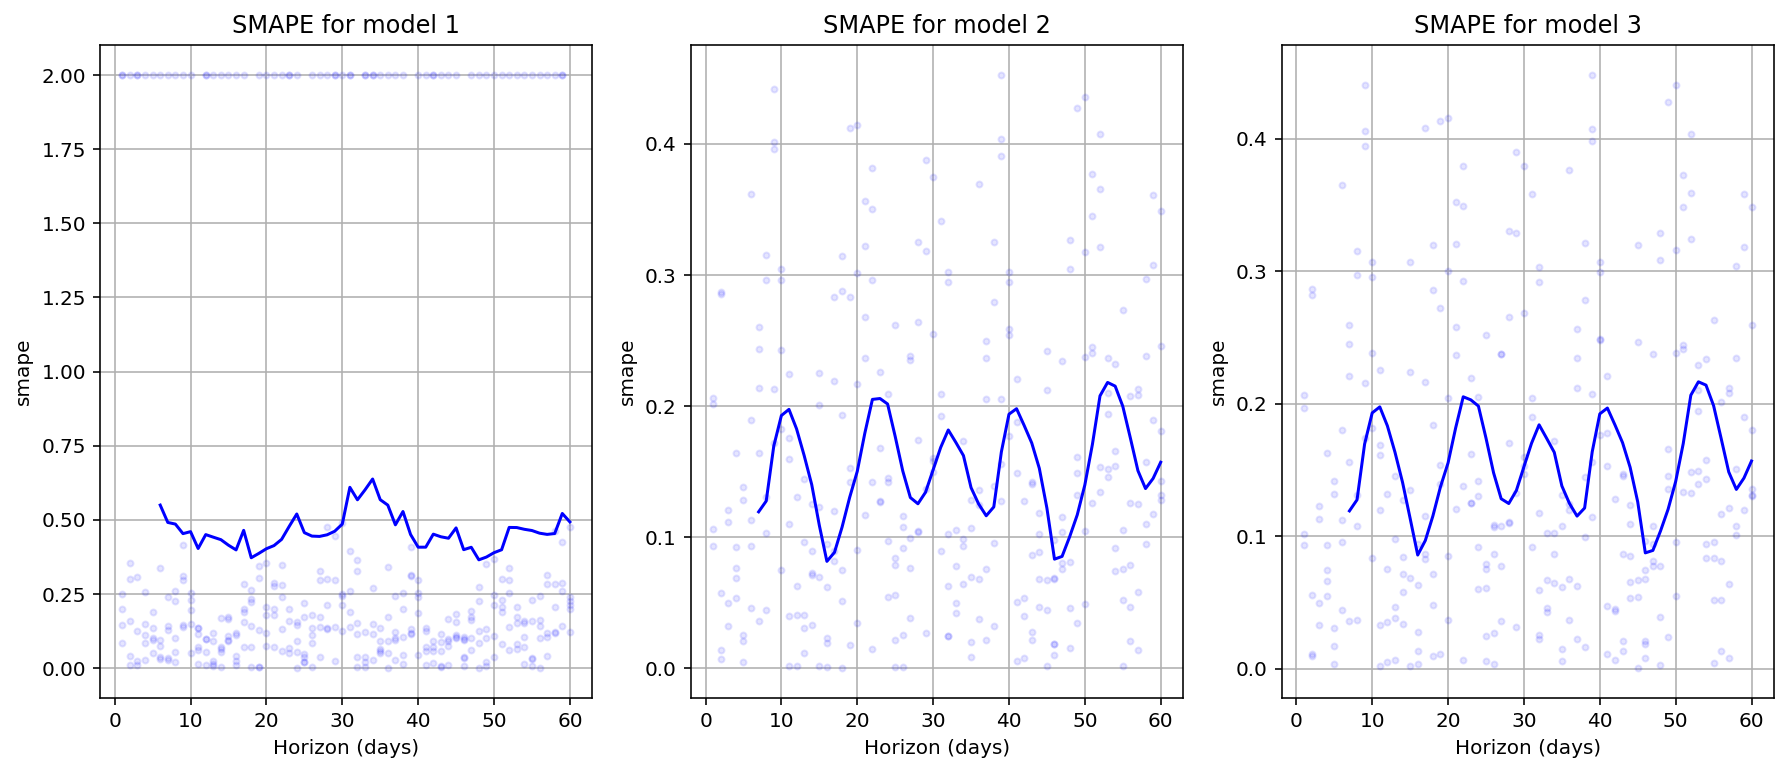

In [68]:
i = 1
fig ,ax = plt.subplots(figsize = (15,6))
for model_name, cdf  in cross_validation_results.items():
    ax = plt.subplot(1, 3, i)
    plot_cross_validation_metric(cdf, metric = 'smape',ax = ax)
    plt.title(f"SMAPE for model {i}")
    i += 1

In [69]:
for model_name, cdf  in cross_validation_results.items():
    p_metric = performance_metrics(cdf)
    print(f"{model_name}:", p_metric['rmse'].mean())

INFO:prophet:Skipping MAPE because y close to 0


model_0: 1004.8815182570897
model_1: 837.9587051569125
model_2: 851.25232746452


In [70]:
for model_name, cdf  in cross_validation_results.items():
    p_metric = performance_metrics(cdf)
    print(f"{model_name}:", p_metric['smape'].mean())

INFO:prophet:Skipping MAPE because y close to 0


model_0: 0.4617461459356448
model_1: 0.1537354463863325
model_2: 0.15416697335429352


In [74]:
cvdf_4 = cross_validation(
            model, 
            initial = "500 days", 
            period = '30 days', 
            horizon = '60 days', 
            disable_tqdm= False
        )


p_metric = performance_metrics(cvdf_4)
clear_output()

In [75]:
p_metric['smape'].mean(), p_metric['rmse'].mean()

(0.15480004566531527, 892.1374790379474)

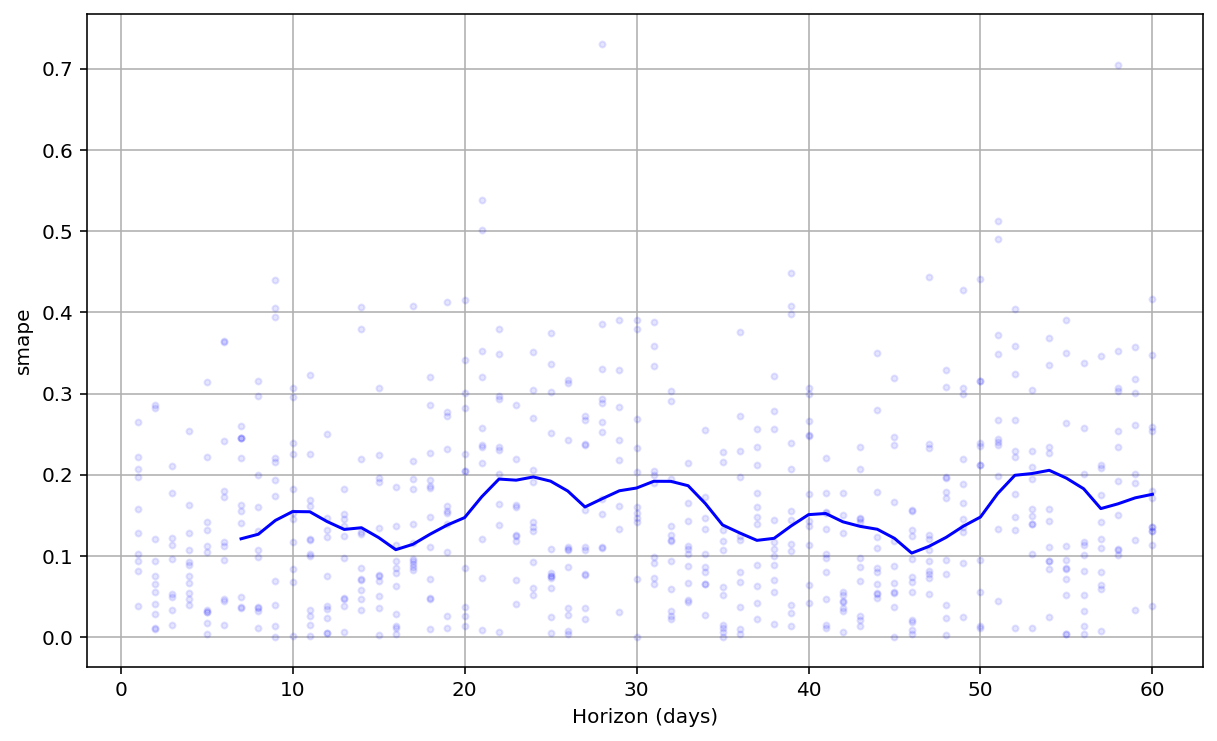

In [76]:
plot_cross_validation_metric(cvdf_4, metric = 'smape')
plt.show()

### Change Point Detection

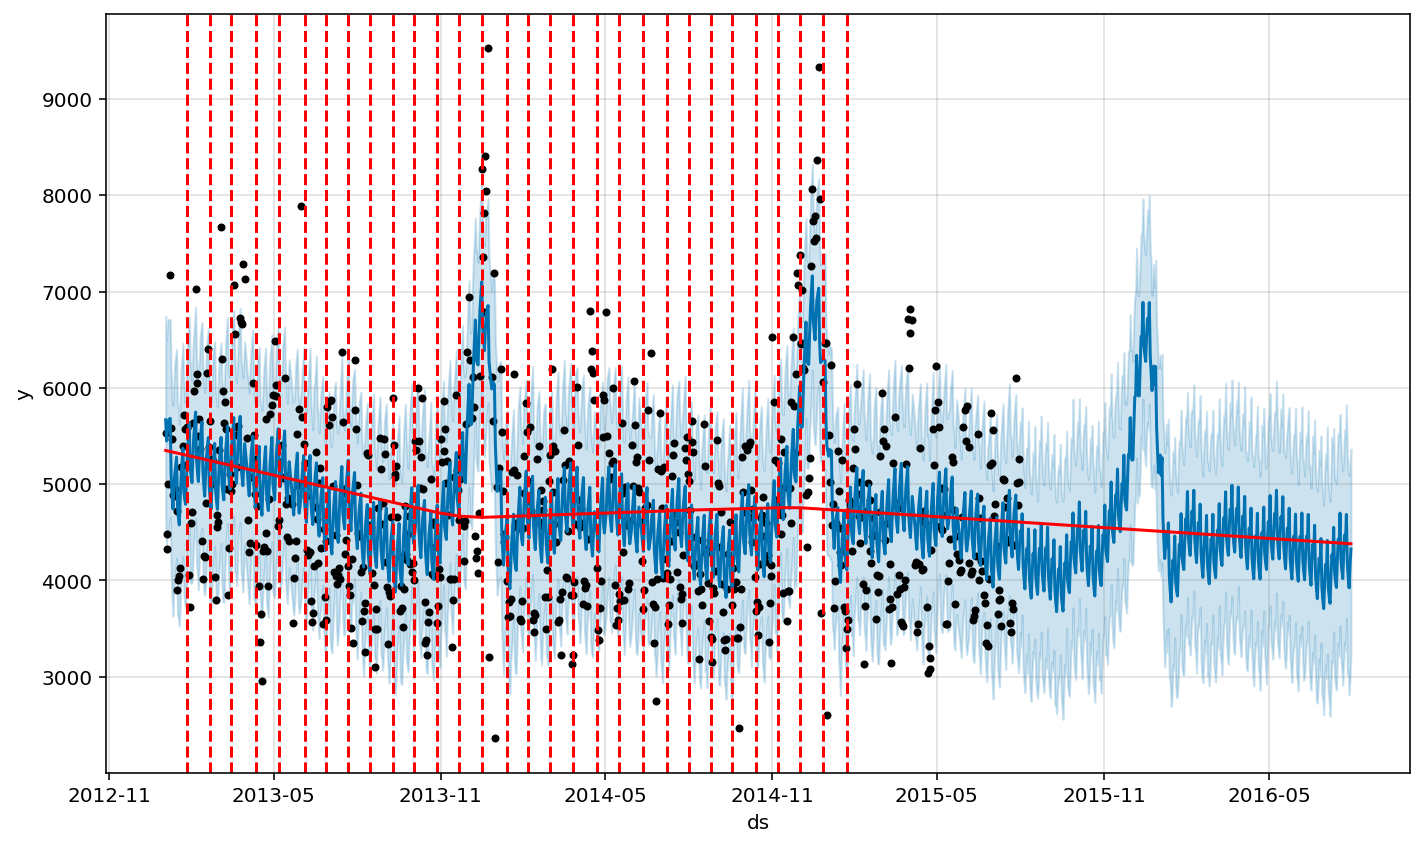

In [75]:
from prophet.plot import add_changepoints_to_plot


data = prophet_clean_pipeline(sales)

m = Prophet(
    n_changepoints=30,
    changepoint_range=.8, 
    changepoint_prior_scale=0.2)

prophet_clean_pipeline = compose(
    store1_pipeline, 
    filter_open_days, 
    make_simple_prophet_data()
)

m.fit(data)
future = m.make_future_dataframe(periods =365)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),m, forecast, threshold=0.0)
clear_output()